# Week 4 - Exploring Semantic Spaces (Word Embeddings)
This week, we build on last week's topic modeling techniques by taking a text corpus we have developed, specifying an underlying number of dimensions, and training a model with a neural network auto-encoder (one of Google's word2vec  algorithms) that best describes corpus words in their local linguistic contexts, and exploring their locations in the resulting space to learn about the discursive culture that produced them.

This is our third document representation we have learned: First, we used word counts. Second, we used LDA topic models built around term coocurrence in the same document (i.e., a "bag of words"). Third, documents here are represented as densely indexed locations in dimensions, so that distances between those documents (and words) contain more information, though they require the full vector of dimension loadings (rather than just a few selected topic loadings) to describe. We will explore these spaces to understand complex, semantic relationships between words, index documents with descriptive words, identify the likelihood that a given document would have been produced by a given vector model, and explore how semantic categories can help us understand the cultures that produced them.

Note that most modern natural language processing (NLP) research, at least in computer science, uses word embeddings. This is the foundation of most state-of-the-art models.

Also note that the code in this Notebook can take many minutes or even hours to run. This is the case for most NLP research these days, and it's a good opportunity to start thinking about how to manage high-compute workloads, such as running code on small samples to test it, loading datafiles in [chunks](https://stackoverflow.com/a/25962187), or [multiprocessing](https://en.wikipedia.org/wiki/Multiprocessing).

## <font color="red">*Pitch Your Project*</font>

<font color="red">In the three cells immediately following, describe **WHAT** you are planning to analyze for your final project (i.e., texts, contexts and the social game, world and actors you intend to learn about through your analysis) (<200 words), **WHY** you are going to do it (i.e., why would theory and/or the average person benefit from knowing the results of your investigation) (<200 words), and **HOW** you plan to investigate it (i.e., what are the approaches and operations you plan to perform, in sequence, to yield this insight) (<400 words).

## <font color="black"> ***What?*** <200 words
* In this project, I plan to analyze the content from the NOW corpus, focusing on articles related to telemedicine and telehealth from 2017 to 2023. The analysis will concentrate on how the integration of telehealth has influenced diagnosis and treatment outcomes for various diseases in the United States, with particular emphasis on remote and underserved areas. The actors in this 'social game' include healthcare providers, patients, policymakers, technology innovators, and insurers. The world under scrutiny is the evolving landscape of healthcare delivery, shaped by technological advancements and societal needs. This analysis aims to uncover patterns, themes, and sentiments surrounding telehealth, exploring how it has been perceived, implemented, and its impacts on healthcare access and quality.

## ***Why?***
* Understanding telehealth's impact is vital for both theoretical and practical reasons. Theoretically, it contributes to the discourse on technology's role in healthcare evolution, particularly in addressing healthcare disparities. Practically, insights from this analysis can inform healthcare providers, policymakers, and technologists about the effectiveness of telehealth, guiding future strategies and investments. For the average person, this research sheds light on the benefits and limitations of telehealth, empowering them with information that could influence their healthcare choices. The study is especially pertinent in a post-pandemic era where telehealth has become more mainstream, yet its long-term role in healthcare delivery remains a subject of debate.

## ***How?*** <400 words
1. Data Processing: Clean and preprocess the data for analysis, including text normalization and categorization.

2. Content Analysis: Use qualitative content analysis to identify themes and patterns regarding telehealth's impact on healthcare delivery, focusing on diagnosis and treatment outcomes.(using all the methods we had in the HW tutorial)

3. Sentiment Analysis: Employ natural language processing tools to assess public sentiment towards telehealth in these articles.

4. Comparative Analysis: Compare the findings across different years to identify trends and changes in the perception and implementation of telehealth.

5. Contextualization: Relate findings to existing literature and data on healthcare delivery and technology use in healthcare.

6. Interpretation and Reporting: Synthesize the insights to form a coherent narrative about telehealth's role and impact in healthcare.

## <font color="red">*Pitch Your Sample*</font>

<font color="red">In the cell immediately following, describe the rationale behind your proposed sample design for your final project. What is the social game, social work, or social actors you about whom you are seeking to make inferences? What are its virtues with respect to your research questions? What are its limitations? What are alternatives? What would be a reasonable path to "scale up" your sample for further analysis (i.e., high-profile publication) beyond this class? (<300 words).

<font color="black">The sample from the NOW corpus is chosen for its recency, diversity, and relevance. It reflects the ongoing 'social game' in healthcare, where various actors (patients, providers, policymakers) navigate the challenges and opportunities presented by telehealth. The sample's virtue lies in its wide coverage, capturing a broad range of perspectives and experiences comparing across the U.S and everywhere else around the globe. However, its limitation is the potential media bias and lack of depth compared to academic or clinical reports, also the popularity gained through post COVID, which is from 2020-2023. Alternatives could include integrating academic journals or patient surveys for a more nuanced view. To scale up, expanding the corpus to include scientific publications and healthcare databases could provide a comprehensive understanding suitable for a high-profile publication.

## ***Which (words)?*** <300 words
The keywords for this analysis will include "telehealth," "telemedicine,"and specific disease names. These words will help identify relevant articles and guide the thematic analysis. The analysis will also focus on words and phrases related to healthcare quality, patient experiences, policy implications, and technological challenges or advancements. This selection is intended to capture the multifaceted nature of telehealth's integration into healthcare systems, its impact on patient care, and the broader societal and policy implications.

In [4]:
#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import lucem_illud #pip install -U git+https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

import numpy as np #For arrays
import pandas as pd #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline
import pandas as pd
import os #For looking through files
import os.path #For managing file paths

# Getting our corpora

Instead of downloading our corpora, we have download them in advance; a subset of the [senate press releases](https://github.com/lintool/GrimmerSenatePressReleases) are in `grimmerPressReleases`. We will load them into a DataFrame, but first we need to define a function to convert directories of text files into DataFrames:

In [7]:
def loadDir(targetDir, category):
    allFileNames = os.listdir(targetDir)
    #We need to make them into usable paths and filter out hidden files
    filePaths = [os.path.join(targetDir, fname) for fname in allFileNames if fname[0] != '.']

    #The dict that will become the DataFrame
    senDict = {
        'category' : [category] * len(filePaths),
        'filePath' : [],
        'text' : [],
    }

    for fPath in filePaths:
        with open(fPath) as f:
# Try this line instead if you get an encoding error.
#         with open(fPath, encoding="ISO-8859-1") as f:
            senDict['text'].append(f.read())
            senDict['filePath'].append(fPath)

    return pd.DataFrame(senDict)

Now we can use the function in all the directories in `data/grimmerPressReleases`. If you are on Google Colab, note that rather than downloading GitHub data to your local machine and then uploading it to Drive, you can more quickly `git clone` directly to Colab, such as `!git clone https://github.com/lintool/GrimmerSenatePressReleases.git /drive/MyDrive/`, which then makes your `dataDir = 'drive/MyDrive/grimmerPressReleases/raw'`.

In [8]:
#dataDir = 'content/drive/MyDrive/grimmerPressReleases/raw'
dataDir = '../data/grimmerPressReleases'

senReleasesDF = pd.DataFrame()

for senatorName in [d for d in os.listdir(dataDir) if d[0] != '.']:
    senPath = os.path.join(dataDir, senatorName)
    senReleasesDF = pd.concat([senReleasesDF, loadDir(senPath, senatorName)], ignore_index=True)


senReleasesDF[:100:10]

,category,filePath,text
0,Kennedy,../data/grimmerPressReleases\Kennedy\01Apr2005...,FOR IMMEDIATE RELEASE FOR IMMEDIATE...
10,Kennedy,../data/grimmerPressReleases\Kennedy\01Dec2005...,FOR IMMEDIATE RELEASE Washington ...
20,Kennedy,../data/grimmerPressReleases\Kennedy\01Feb2006...,FOR IMMEDIATE RELEASE Fact sheet...
30,Kennedy,../data/grimmerPressReleases\Kennedy\01Feb2007...,FOR IMMEDIATE RELEASE Washington ...
40,Kennedy,../data/grimmerPressReleases\Kennedy\01Jun2007...,FOR IMMEDIATE RELEASE BOSTON MA Se...
50,Kennedy,../data/grimmerPressReleases\Kennedy\01Mar2007...,FOR IMMEDIATE RELEASE Washington ...
60,Kennedy,../data/grimmerPressReleases\Kennedy\01May2007...,FOR IMMEDIATE RELEASE The President ...
70,Kennedy,../data/grimmerPressReleases\Kennedy\01Nov2007...,FOR IMMEDIATE RELEASE Washington DC...
80,Kennedy,../data/grimmerPressReleases\Kennedy\02Aug2006...,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...
90,Kennedy,../data/grimmerPressReleases\Kennedy\02Feb2005...,FOR IMMEDIATE RELEASE The Preside...


Word2Vec needs to retain the sentence structure so as to capture a "continuous bag of words (CBOW)" and all of the skip-grams within a word window. The algorithm tries to preserve the distances induced by one of these two local structures. This is very different from clustering and LDA topic modeling which extract unordered words alone.

When we normalize here, we don't use the lematized form of the word because we might lose information. Note the paramter in the normalize tokens function.

In [9]:
#Apply our functions, notice each row is a list of lists now
senReleasesDF['tokenized_sents'] = senReleasesDF['text'].apply(lambda x: [lucem_illud.word_tokenize(s) for s in lucem_illud.sent_tokenize(x)])
senReleasesDF['normalized_sents'] = senReleasesDF['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s, lemma=False) for s in x])
# With the latest spacy versions, you may get warnings with the following line of code. See the discussion here: https://github.com/allenai/allennlp/issues/5036
# senReleasesDF['normalized_sents'] = senReleasesDF['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s) for s in x])

senReleasesDF[:100:10]

c:\Users\flori\AppData\Local\Programs\Python\Python39\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


,category,filePath,text,tokenized_sents,normalized_sents
0,Kennedy,../data/grimmerPressReleases\Kennedy\01Apr2005...,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,"[[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...","[[immediate, release, immediate, release, cont..."
10,Kennedy,../data/grimmerPressReleases\Kennedy\01Dec2005...,FOR IMMEDIATE RELEASE Washington ...,"[[FOR, IMMEDIATE, RELEASE, Washington, D, C], ...","[[immediate, release, washington, d, c], [toda..."
20,Kennedy,../data/grimmerPressReleases\Kennedy\01Feb2006...,FOR IMMEDIATE RELEASE Fact sheet...,"[[FOR, IMMEDIATE, RELEASE, Fact, sheets, on, B...","[[immediate, release, fact, sheets, bush, s, p..."
30,Kennedy,../data/grimmerPressReleases\Kennedy\01Feb2007...,FOR IMMEDIATE RELEASE Washington ...,"[[FOR, IMMEDIATE, RELEASE, Washington, D, C, T...","[[immediate, release, washington, d, c, today,..."
40,Kennedy,../data/grimmerPressReleases\Kennedy\01Jun2007...,FOR IMMEDIATE RELEASE BOSTON MA Se...,"[[FOR, IMMEDIATE, RELEASE, BOSTON, MA, Senator...","[[immediate, release, boston, ma, senator, edw..."
50,Kennedy,../data/grimmerPressReleases\Kennedy\01Mar2007...,FOR IMMEDIATE RELEASE Washington ...,"[[FOR, IMMEDIATE, RELEASE, Washington, DC, Tod...","[[immediate, release, washington, dc, today, s..."
60,Kennedy,../data/grimmerPressReleases\Kennedy\01May2007...,FOR IMMEDIATE RELEASE The President ...,"[[FOR, IMMEDIATE, RELEASE, The, President, is,...","[[immediate, release, president, wrong, veto, ..."
70,Kennedy,../data/grimmerPressReleases\Kennedy\01Nov2007...,FOR IMMEDIATE RELEASE Washington DC...,"[[FOR, IMMEDIATE, RELEASE, Washington, DC, Sen...","[[immediate, release, washington, dc, senators..."
80,Kennedy,../data/grimmerPressReleases\Kennedy\02Aug2006...,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,"[[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...","[[immediate, release, immediate, release, impo..."
90,Kennedy,../data/grimmerPressReleases\Kennedy\02Feb2005...,FOR IMMEDIATE RELEASE The Preside...,"[[FOR, IMMEDIATE, RELEASE, The, President, gav...","[[immediate, release, president, gave, effecti..."


# Word2Vec

We will be using the gensim implementation of [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec). Note that newer versions of gensim have different syntax, but if you're using a newer version, you should see informative error messages (e.g., replace `senReleasesW2V['president'][:10]` with `senReleasesW2V['president'].wv[:10]`). The following lines should work out-of-the-box on Google Colab.

To load our data our data we give all the sentences to the trainer:

In [10]:
# The sg=0 argument indicates that we don't want to use "skipgram" but instead "CBOW"
senReleasesW2V = gensim.models.word2vec.Word2Vec(senReleasesDF['normalized_sents'].sum(), sg=0)

Inside the word2vec object, each word has a vector. To access the vector directly, use the square braces (`__getitem__`) method:

In [9]:
# Fixed below 
senReleasesW2V.wv['president'][:10] #Shortening because it's very large

array([-3.339274  , -0.5437525 , -0.1226134 , -1.0288898 ,  0.8050365 ,
       -0.00481207,  2.0230625 ,  0.6769619 , -2.2679005 ,  0.58129245],
      dtype=float32)

If you want the full matrix, `syn0` stores all the vectors:

In [13]:
# fixed, syn0 deprecated 
senReleasesW2V.wv.vectors
#senReleasesW2V.wv.get_normed_vectors()

array([[ 1.1430479 ,  0.65822345,  0.97865224, ..., -0.8771476 ,
         1.8521914 ,  0.86021614],
       [-1.3200283 ,  1.1291305 ,  0.6752937 , ..., -1.7128541 ,
        -0.12565644,  0.8412019 ],
       [ 1.2646033 ,  1.1135089 ,  0.78786606, ...,  1.4739097 ,
         0.05045663,  0.18112522],
       ...,
       [ 0.04517063,  0.00488359,  0.02894049, ..., -0.00671313,
        -0.01906217, -0.00243858],
       [-0.02570985,  0.07324397, -0.01579603, ..., -0.08277202,
         0.02489039, -0.00897171],
       [-0.03648366,  0.09436288,  0.03211064, ..., -0.05207127,
         0.04933215, -0.05567212]], dtype=float32)

Then, `index2word` lets you translate from the matrix to words:

In [15]:
senReleasesW2V.wv.index_to_key[10]

'american'

Now we can look at a few things that come from the word vectors. The first is to find similar vectors (cosine similarity):

In [18]:
senReleasesW2V.wv.most_similar('president')

[('administration', 0.785071849822998),
 ('presidents', 0.7719882726669312),
 ('administrations', 0.6723802089691162),
 ('prioritizes', 0.6237578392028809),
 ('cheney', 0.6058061122894287),
 ('george', 0.5837770104408264),
 ('responds', 0.5656358003616333),
 ('veto', 0.5458326935768127),
 ('presidential', 0.5309112071990967),
 ('kenna', 0.5305079221725464)]

In [21]:
senReleasesW2V.wv.most_similar('war')

[('wars', 0.6684772968292236),
 ('disobedience', 0.6644299030303955),
 ('unresisted', 0.6457504034042358),
 ('quagmire', 0.6302472352981567),
 ('chaos', 0.621263861656189),
 ('compounding', 0.6191334128379822),
 ('afghanistan', 0.6131693124771118),
 ('descending', 0.6052805781364441),
 ('invasion', 0.5973867177963257),
 ('liberation', 0.5867765545845032)]

Find which word least matches the others within a word set (cosine similarity):

In [23]:
senReleasesW2V.wv.doesnt_match(['administration', 'administrations', 'presidents', 'president', 'washington'])

'washington'

Find which word best matches the result of a semantic *equation* (here, we seek the words whose vectors best fit the missing entry from the equation: **X + Y - Z = _**.

In [25]:
senReleasesW2V.wv.most_similar(positive=['clinton', 'republican'], negative = ['democrat'])

[('blocked', 0.6564346551895142),
 ('vetoes', 0.6323485374450684),
 ('veto', 0.6148660778999329),
 ('signing', 0.6106489300727844),
 ('proposing', 0.6040289402008057),
 ('signed', 0.6038020253181458),
 ('bush', 0.5848245620727539),
 ('reverse', 0.5799790620803833),
 ('vetoed', 0.563617467880249),
 ('nixon', 0.5633360743522644)]

Here we see that **Clinton + Republican - Democrat = Bush**. In other words, in this dataset, **Clinton** is to **Democrat** as **Bush** is to **Republican**. Whoah!

We can also save the vectors for later use:

In [26]:
senReleasesW2V.save("senpressreleasesWORD2Vec")

We can also use dimension reduction to visulize the vectors. We will start by selecting a subset we want to plot. Let's look at the top words from the set:

In [28]:
numWords = 50
targetWords = senReleasesW2V.wv.index_to_key[:numWords]

We can then extract their vectors and create our own smaller matrix that preserved the distances from the original:

In [30]:
# Fixed below, old code deprecated
wordsSubMatrix = []
for word in targetWords:
    if word in senReleasesW2V.wv:  # Check if the word exists in the model
        wordsSubMatrix.append(senReleasesW2V.wv[word])
wordsSubMatrix = np.array(wordsSubMatrix)


Then we can use PCA to reduce the dimesions (e.g., to 50), and T-SNE to project them down to the two we will visualize. We note that this is nondeterministic process, and so you can repeat and achieve alternative projectsions/visualizations of the words:

In [31]:
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)

We now can plot the points

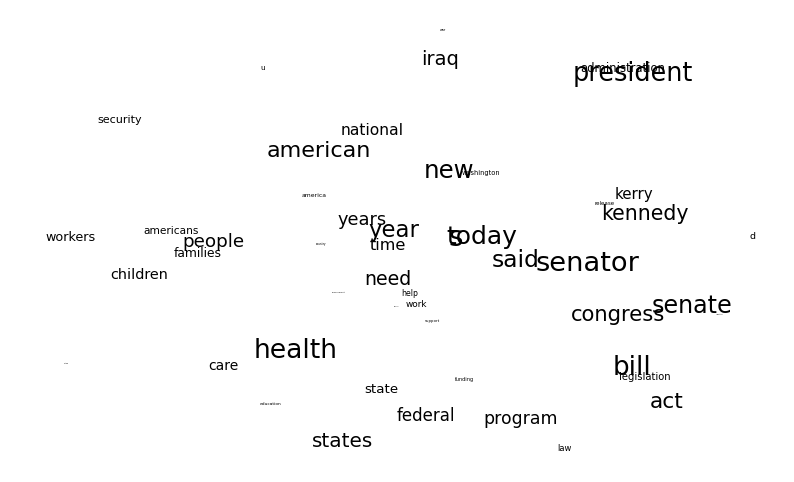

In [32]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

My visualization above puts ``said`` next to ``congress`` and ``bill`` near ``act``. ``health`` is beside ``care`` and ``national`` abuts ``security``.

# Chinese examples
The following datafile is [available on Canvas](https://canvas.uchicago.edu/courses/39937/files/6674623/download). The Chinese word2vec model we use in this assignment was made with an old version of Gensim. If you have a version of '4.0.0' or later, you can run code like `!pip install gensim==3.8.3` (the last v3 of Gensim before v4) and restart your notebook to load that file. However, it's usually best to use the most recent stable versions of Python packages, so you can skip this section and go straight to the FastText section if you would like.

In [33]:
# !pip install gensim==3.8.3

In [7]:
import gensim
gensim.__version__

'4.3.2'

In [12]:
# If your version is 4.0.0 or later, this code will raise `AttributeError: Can't get attribute 'Vocab'...`
# You can load an old version of Gensim or skip to FastText.

# This does not work, word2vec attibute error 
# from gensim.models import KeyedVectors
# model = KeyedVectors.load('../data/1992embeddings_hs_new3.sg')

## analogy

King+man-Queen? A few examples based on a corpus of Chinese news. 

First, location analogy: **province -> capital**

In [ ]:
mm = model.wv.most_similar(positive=[u'长沙',u'陕西'], negative=[u'湖南']) # Changsha + Shaanxi - Hunan
for m in mm:
    print(m[0],m[1])
    print("Xi'an")
    break

In [8]:
mm = model.wv.most_similar(positive=[u'广州',u'湖北'], negative=[u'广东']) # Guangzhou + Hubei - Guangdong
for m in mm:
    print(m[0],m[1])
    print("Wuhan")
    break

武汉 0.3677000403404236
Wuhan


Second, location analogy: **country -> capital**

In [11]:
mm = model.wv.most_similar(positive=[u'东京',u'美国'], negative=[u'日本']) # Tokyo + US - Japan
for m in mm:
    print(m[0],m[1])
    print("(Washington DC)")
    break

华盛顿 0.508813738822937
(Washington DC)


## similar words

In [9]:
word = u'社会主义'  #socialism
ss = model.wv.similar_by_word(word,topn=10)
print("the most similar words to " + word + " is: ")
for s in ss:
    print(s[0])
print("")

the most similar words to 社会主义 is: 
特色
市场经济
理论
建设
改革开放
马克思主义
党
经济体制
基本路线
现代化



In [10]:
#@title
word = u'玉米'  # corn
ss = model.wv.similar_by_word(word,topn=10)
print("the most similar words to " + word + " is: ")
for s in ss:
    print(s[0])
print("")

the most similar words to 玉米 is: 
小麦
水稻
作物
棉花
新品种
杂交
大豆
增产
栽培
农作物



## Adding more context - FastText

Since the original word2vec paper, there have followed a slew of word embedding related methods which innovate and build on them in many ways. One popular extension is FastText ([Bojanowski et al. 2017](https://arxiv.org/abs/1607.04606)), which uses sub-words to generate its vectors. Using subwords means that it is powerful in dealing with unknown words and sparse languages that otherwise have a rich morphological structure. These sub-words are incorporated into the previously skipgram and CBOW methods. For example, if the word is “which”, it is represented as the word itself along with a bag of constituent n-grams. If n=3, the representation looks like <wh, whi, hic, ich, ch>, and we learn a representation for each of these constituents, with the word “which” taking on the average value of these constituents. 

FastText can be used either via Gensim or the official package, and primarily has two functions - word representations, and text classification (Joulin et al. 2017). See below for code using the FastText package for playing with word representations, taken from their word representations tutorial (https://fasttext.cc/docs/en/unsupervised-tutorial.html).


### Representations with FastText

We will follow the instructions in the FastText tutorial to prepare our data, (Wikipedia). You can either follow the instructions on the page for setting the data, or download/copy it to drive it from this [Google Drive link](https://drive.google.com/file/d/12T3nNzf0a7tdhm1lVyfz9Ix9XVITFMCP/view?usp=sharing). 

In this example, we will be training a model - it is also possible to download and use the many pre-trained models.

In [ ]:
!   pip install fasttext

In [14]:
import fasttext

In [15]:
# Replace with the path for where you have placed the 'fil9' file.
file_address = "../data/fil9" 

In [16]:
model = fasttext.train_unsupervised(file_address)

While FastText is running, the progress and estimated time to completion is shown on your screen. Once the training finishes, the model variable contains information on the trained model, which you can use for querying:



In [17]:
model.words

['the',
 'of',
 'and',
 'in',
 'a',
 'to',
 'is',
 'The',
 'are',
 'for',
 'was',
 'as',
 'with',
 'by',
 'from',
 'that',
 'on',
 'or',
 'at',
 'an',
 'his',
 'have',
 'which',
 'it',
 'In',
 'be',
 'age',
 'also',
 'he',
 'has',
 'were',
 'not',
 'who',
 'had',
 'population',
 'this',
 'but',
 'km',
 'other',
 'there',
 'their',
 'one',
 'under',
 'A',
 'more',
 '18',
 'its',
 'all',
 'living',
 'first',
 'two',
 'income',
 'median',
 'been',
 'It',
 'out',
 'total',
 'United',
 'can',
 'For',
 'years',
 'they',
 'This',
 'He',
 'into',
 'There',
 'most',
 'city',
 'average',
 'As',
 'such',
 'used',
 '65',
 'some',
 'up',
 'no',
 'mi.',
 'New',
 'those',
 'many',
 'only',
 'made',
 'after',
 'than',
 'would',
 'when',
 'American',
 'family',
 'area',
 'any',
 'every',
 'States',
 'town',
 '100',
 'known',
 'links',
 'External',
 'her',
 'about',
 'County,',
 'located',
 'size',
 'below',
 'may',
 'between',
 'over',
 'time',
 '1',
 'families',
 'density',
 'line.',
 'called',
 'hous

It returns all words in the vocabulary, sorted by decreasing frequency. We can get the word vector by:



In [18]:
model.get_word_vector("the")

array([-0.12084085,  0.5492327 ,  0.0824696 ,  0.25363284,  0.16262709,
       -0.02627787,  0.15184522, -0.36438525,  0.1561611 , -0.15111226,
       -0.14854863,  0.39425808, -0.14802296, -0.04988571, -0.14429899,
       -0.2758176 ,  0.13358852,  0.12636864,  0.10071614, -0.16773364,
        0.1516089 , -0.34079668,  0.12077007,  0.02961084, -0.0776622 ,
        0.14134811,  0.02414101,  0.00145983, -0.1917183 , -0.14426902,
       -0.1470465 , -0.30601707, -0.49832803,  0.33195972, -0.02393164,
       -0.21722761, -0.2858986 ,  0.16486104,  0.21934229, -0.39469618,
        0.34504348, -0.0652067 , -0.26527378,  0.14147866,  0.20526484,
       -0.19235304,  0.20296623, -0.10101476,  0.35429314, -0.15827215,
        0.18851267,  0.38034886,  0.23086615, -0.15060647,  0.59239006,
        0.0562493 ,  0.06682047, -0.144577  ,  0.2047312 , -0.23512313,
        0.0673046 , -0.06902941, -0.04678788,  0.01321285, -0.09126817,
        0.16557378,  0.14707218, -0.44564018, -0.3024399 ,  0.06

In [21]:
model.save_model("fil9.bin")

In [ ]:
# when we want to use the model again
# model = fasttext.load_model("result/fil9.bin")

Let's now print some vectors.

In [22]:
[model.get_word_vector(x) for x in ["asparagus", "pidgey", "yellow"]]

[array([-0.3763287 , -0.02100678,  0.02126971, -0.01483327,  0.22347632,
         0.6634899 , -0.20518024,  0.22311293,  0.05510181,  0.5904435 ,
        -0.66595525, -0.21292585,  0.00141425, -0.6587982 , -0.18682112,
        -0.3896631 ,  0.56355506, -0.1778658 , -0.33277813,  0.1710207 ,
        -0.46703187,  0.0231634 ,  1.3937211 , -0.36724585,  0.0749626 ,
        -0.31991848,  0.6740487 ,  0.40683705, -0.82269216, -0.07713571,
        -0.06215599, -0.446606  , -0.59928936, -0.09234824, -0.4529319 ,
         0.17759193,  0.13994248,  0.31215885,  0.08350032,  0.12279519,
         0.37789991, -0.09267162,  0.18954419, -0.03997714,  0.29410324,
        -0.41865632,  0.0222857 ,  0.47887844,  0.337929  ,  0.41773447,
         0.53514075,  0.20425612,  1.0710332 , -0.07406529,  0.6971432 ,
         0.29639402, -0.37371024,  0.06249844, -0.0764751 , -0.48249257,
         0.7680072 ,  0.27765307, -0.44492662,  0.28673238,  0.25497812,
        -0.19436537,  0.24517936,  0.01953148, -0.1

A nice feature is that you can also query for words that did not appear in your data! Indeed words are represented by the sum of their substrings. As long as the unknown word is made of known substrings, there is a representation of it!

As an example let's try with a misspelled word:



In [23]:
model.get_word_vector("enviroment")

array([-0.4735461 ,  0.5617258 , -0.0016778 , -0.35148996,  0.08480728,
       -0.00768573, -0.23641457, -0.1090412 , -0.05643427, -0.5121541 ,
       -0.02709121,  0.08575584, -0.08540152, -0.00864455, -0.12157645,
       -0.32767427,  0.4073872 ,  0.10039073, -0.06684525,  0.17778029,
       -0.11203866, -0.03035674, -0.14215042,  0.6352458 ,  0.10427472,
        0.01502893,  0.5112806 ,  0.15588784, -0.10575185, -0.2517806 ,
       -0.01148977, -0.25917512, -0.37758228,  0.15656598,  0.06017482,
        0.08907361,  0.1884946 ,  0.24773757, -0.11431044, -0.20159173,
        0.2875486 , -0.0774234 , -0.02044008,  0.10987043,  0.3273795 ,
       -0.09788097,  0.19320959,  0.53570604,  0.26253262, -0.29055685,
        0.6206654 ,  0.11293212,  0.25654933, -0.15659463,  0.11069861,
        0.21961293, -0.5373954 ,  0.40038005, -0.205428  , -0.4603613 ,
        0.29188183,  0.22372898, -0.00363764, -0.17657691,  0.32063958,
       -0.05321747,  0.43827978, -0.16973016, -0.16368032, -0.04

In [ ]:
# Add FastText here

## <font color="red">*Exercise 1*</font>

<font color="red">Construct cells immediately below this that embed documents related to your final project using at least two different specification of `word2vec` and/or `fasttext`, and visualize them each with two separate visualization layout specifications (e.g., TSNE, PCA). Then interrogate critical word vectors within your corpus in terms of the most similar words, analogies, and other additions and subtractions that reveal the structure of similarity and difference within your semantic space. What does this pattern reveal about the semantic organization of words in your corpora? Which estimation and visualization specification generate the most insight and appear the most robustly supported and why? 

<font color="red">***Stretch***: Explore different vector calculations beyond addition and subtraction, such as multiplication, division or some other function. What does this exploration reveal about the semantic structure of your corpus?

In [60]:
merged_df= pd.read_csv("D:/NOW/output_files/final_df_withtoken.csv")

In [65]:
merged_df['normalized_tokens'] 

0        ['grow', 'rapidly', 'expect', 'grow', 'cagr', ...
1        ['community', 'own', 'profit', 'organisation',...
2        ['clinician', 'government', 'improve', 'broadb...
3        ['market', 'segment', 'region', 'report', 'spl...
4        ['market', 'study', 'expect', 'growth', 'criti...
                               ...                        
25589    ['overthecounter', 'hearing', 'aid', 'gain', '...
25590    ['technology', 'datum', 'improve', 'sa', 'heal...
25591    ['dr', 'razi', 'say', 'sehat', 'kahani', 'incr...
25592    ['georgie', 'allow', 'specialist', 'groote', '...
25593    ['telco', 'sector', 'policy', 'win', 'loss', '...
Name: normalized_tokens, Length: 25594, dtype: object

In [66]:
import ast
from itertools import chain

# Convert string representations of lists back to actual lists
merged_df['normalized_tokens'] = merged_df['normalized_tokens'].apply(ast.literal_eval)
print(merged_df['normalized_tokens'])

# flatten the list of lists
#flat_list = list(chain.from_iterable(merged_df['normalized_tokens']))

0        [grow, rapidly, expect, grow, cagr, end, digit...
1        [community, own, profit, organisation, offer, ...
2        [clinician, government, improve, broadband, bu...
3        [market, segment, region, report, split, globa...
4        [market, study, expect, growth, critical, care...
                               ...                        
25589    [overthecounter, hearing, aid, gain, traction,...
25590    [technology, datum, improve, sa, healthcare, t...
25591    [dr, razi, say, sehat, kahani, incredible, hea...
25592    [georgie, allow, specialist, groote, schuur, h...
25593    [telco, sector, policy, win, loss, dec, policy...
Name: normalized_tokens, Length: 25594, dtype: object


In [67]:
# The sg=0 argument indicates that we don't want to use "skipgram" but instead "CBOW"
healthW2V = gensim.models.word2vec.Word2Vec(merged_df['normalized_tokens'], sg=0)

In [68]:
healthW2V.wv['telehealth']

array([-3.16662580e-01, -2.20595121e+00,  1.51270747e+00,  3.10371208e+00,
        8.21577609e-01, -2.33217311e+00,  4.70458001e-01, -6.66949511e-01,
       -1.40864396e+00,  2.26865864e+00,  1.62006164e+00, -2.73263939e-02,
       -4.29105014e-02, -1.94992721e+00,  1.39438188e+00, -1.16996634e+00,
       -1.00320554e+00,  2.33437324e+00,  2.72206211e+00,  5.29902816e-01,
       -7.88265705e-01, -6.17383540e-01,  7.36331820e-01, -1.32486820e+00,
       -8.14809144e-01, -1.13102116e-01,  5.83346546e-01,  1.45661557e+00,
        1.23462236e+00,  1.58947599e+00,  1.65841341e+00, -2.52256989e-01,
       -3.75457504e-03, -5.34940422e-01, -9.79822338e-01,  2.60232496e+00,
        1.89822721e+00, -3.46929359e+00,  4.27491814e-01,  3.07009029e+00,
        3.73137832e-01,  1.07809687e+00,  2.54854345e+00,  2.07452569e-02,
        2.32883120e+00, -2.81469792e-01,  6.45582020e-01, -7.61056721e-01,
       -2.46645975e+00,  8.50818455e-02, -3.14181566e-01, -1.92330623e+00,
       -2.78497720e+00,  

In [69]:
healthW2V.wv.vectors

array([[-1.01076269e+00, -2.37712359e+00,  2.06650496e+00, ...,
        -1.10075510e+00, -1.48903370e+00,  2.91781950e+00],
       [ 5.06252110e-01, -4.26470071e-01, -7.83601999e-01, ...,
         8.08919847e-01, -9.22438443e-01,  8.43396962e-01],
       [-2.77029943e+00, -4.26501662e-01,  3.15598202e+00, ...,
         5.08717835e-01, -2.51372075e+00, -4.93604243e-01],
       ...,
       [-5.57998866e-02, -1.21154286e-01, -1.92171991e-01, ...,
        -1.43398866e-02, -2.02536187e-03,  4.79577258e-02],
       [ 9.02965572e-03,  9.22396332e-02, -1.11125626e-01, ...,
        -1.33180514e-01,  1.74630024e-02, -5.38436659e-02],
       [ 1.14230774e-02,  2.24552844e-02, -1.62145615e-01, ...,
        -3.28330509e-02,  1.54797202e-02, -1.19468510e-01]], dtype=float32)

In [70]:
healthW2V.wv.index2word[5]

'people'

In [71]:
healthW2V.wv.most_similar('telehealth')

[('telemedicine', 0.8730279207229614),
 ('virtual', 0.7297186255455017),
 ('teletherapy', 0.6407236456871033),
 ('telepsychiatry', 0.6350386142730713),
 ('audioonly', 0.6202576160430908),
 ('inperson', 0.6029384136199951),
 ('teleconsultation', 0.5853939652442932),
 ('remote', 0.5723277926445007),
 ('facetoface', 0.5675340294837952),
 ('rpm', 0.5524615049362183)]

In [85]:
healthW2V.wv.most_similar('hospital')

[('icu', 0.6738758683204651),
 ('icus', 0.630149245262146),
 ('inpatient', 0.6286423206329346),
 ('facility', 0.5930378437042236),
 ('ward', 0.5777820944786072),
 ('er', 0.5563374757766724),
 ('clinic', 0.554858922958374),
 ('bed', 0.5519610643386841),
 ('outpatient', 0.5417864322662354),
 ('noncovid19', 0.5148099660873413)]

In [82]:
#healthW2V.wv.doesnt_match(['telehealth', 'telemedicine', 'health', 'COVID', 'disease'])

from gensim.models import Word2Vec

words = ['telehealth', 'telemedicine', 'health', 'COVID', 'disease']

# Compute mean vector
mean_vector = np.mean([healthW2V.wv[word] for word in words if word in healthW2V.wv], axis=0)

# Find the word furthest from the mean vector
distances = {word: np.linalg.norm(healthW2V.wv[word] - mean_vector) for word in words if word in healthW2V.wv}
outlier_word = max(distances, key=distances.get)

print(outlier_word)


disease


In [86]:
healthW2V.wv.most_similar(positive=['telehealth', 'hospital'], negative = ['covid'])

[('telemedicine', 0.6561323404312134),
 ('virtual', 0.5319477319717407),
 ('econsult', 0.5262576341629028),
 ('oncall', 0.5258431434631348),
 ('inhome', 0.525536298751831),
 ('telepsychiatry', 0.5248944163322449),
 ('telestroke', 0.5154898762702942),
 ('primarycare', 0.508059561252594),
 ('rpm', 0.5053086876869202),
 ('clinic', 0.5013098120689392)]

In [87]:
healthW2V.save("telehealthWORD2Vec")

In [102]:
import numpy as np
import sklearn.decomposition
import sklearn.manifold
#index_to_key
# Filter out words with apostrophes
numWords = 50
#targetWords = healthW2V.wv.index2word[:numWords]
targetWords = [word for word in healthW2V.wv.index2word[:numWords] if "'" not in word]

wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(healthW2V.wv[word])
wordsSubMatrix = np.array(wordsSubMatrix)

pcaWords = sklearn.decomposition.PCA(n_components=50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
# T-SNE is theoretically better
tsneWords = sklearn.manifold.TSNE(n_components=2).fit_transform(reducedPCA_data)

In [221]:
# fig = plt.figure(figsize = (10,6))
# ax = fig.add_subplot(111)
# ax.set_frame_on(False)
# plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
# for i, word in enumerate(targetWords):
#     ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
# plt.xticks(())
# plt.yticks(())
# plt.show()

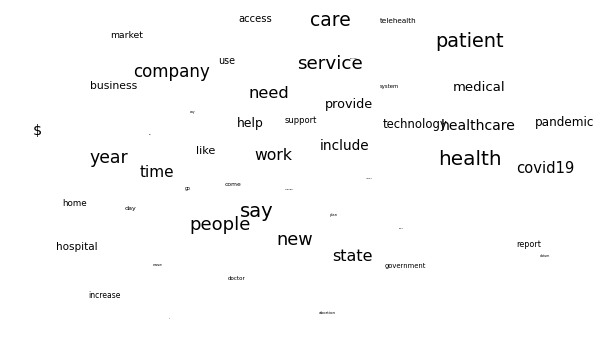

In [103]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha=0)  # Making the points invisible
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i], tsneWords[:, 1][i]), size=20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

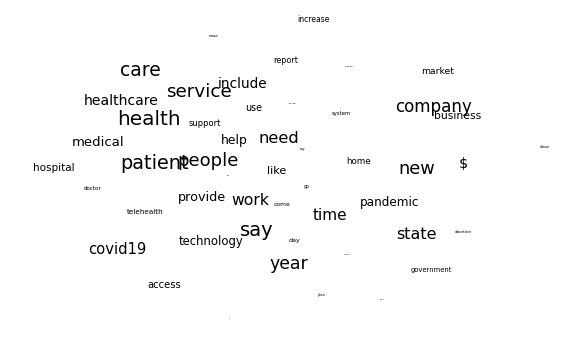

In [106]:
import numpy as np
import sklearn.manifold
import matplotlib.pyplot as plt

# Filter out words with apostrophes
numWords = 50
targetWords = [word for word in healthW2V.wv.index2word[:numWords] if "'" not in word]

wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(healthW2V.wv[word])
wordsSubMatrix = np.array(wordsSubMatrix)

# T-SNE is used for dimensionality reduction
tsneWords = sklearn.manifold.TSNE(n_components=2).fit_transform(wordsSubMatrix)

# Plotting the word vectors using t-SNE
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha=0)  # Making the points invisible
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i], tsneWords[:, 1][i]), size=20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

In [110]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np

def plot_word_vectors(model, words_list):
    # Filter the list to include only words present in the model's vocabulary
    filtered_words = [word for word in words_list if word in model.wv]
    
    # Extract the word vectors from the model
    word_vectors = np.array([model.wv[word] for word in filtered_words])
    
    # PCA Visualization
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(word_vectors)
    
    plt.figure(figsize=(13, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(pca_result[:, 0], pca_result[:, 1])
    for i, word in enumerate(filtered_words):
        plt.annotate(word, xy=(pca_result[i, 0], pca_result[i, 1]), alpha=0.7)
    plt.title('PCA Visualization of Word Vectors')
    
    # t-SNE Visualization
    tsne = TSNE(n_components=2, random_state=0)
    tsne_result = tsne.fit_transform(word_vectors)
    
    plt.subplot(1, 2, 2)
    plt.scatter(tsne_result[:, 0], tsne_result[:, 1])
    for i, word in enumerate(filtered_words):
        plt.annotate(word, xy=(tsne_result[i, 0], tsne_result[i, 1]), alpha=0.7)
    plt.title('t-SNE Visualization of Word Vectors')
    
    plt.show()


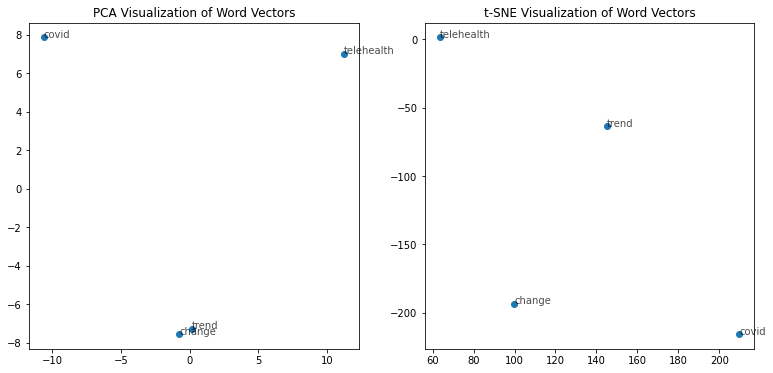

Result of subtract between telehealth and trend:
telehealth: 0.6421
telemedicine: 0.5652
teletherapy: 0.5577
audioonly: 0.5432
concierge: 0.5249
videovisit: 0.5205
outofnetwork: 0.5075
distancelearne: 0.5059
aroundtheclock: 0.5037
econsult: 0.5000
Result of subtract between telehealth and change:
telemedicine: 0.6728
telehealth: 0.6625
teleconsultation: 0.5698
teletherapy: 0.5607
telepsychiatry: 0.5432
tele: 0.5295
telestroke: 0.5295
akos: 0.5235
virtualcare: 0.5226
econsult: 0.5220
Result of multiply between telehealth and covid:
wellbee: 0.3726
society: 0.3692
organisation: 0.3413
collective: 0.3300
eing: 0.3237
rouleau: 0.3228
wellbeing: 0.3168
livelihood: 0.3153
sense: 0.3107
primacy: 0.3097


In [114]:
from scipy.spatial.distance import cosine

def explore_vector_operations(model, word1, word2, operation):
    vec1 = model.wv[word1]
    vec2 = model.wv[word2]
    
    if operation == 'add':
        result_vector = vec1 + vec2
    elif operation == 'subtract':
        result_vector = vec1 - vec2
    elif operation == 'multiply':
        result_vector = vec1 * vec2
    elif operation == 'divide':
        # Avoid division by zero
        result_vector = vec1 / (vec2 + 1e-5)
    else:
        raise ValueError("Unsupported operation")
    
    # Find the closest words to the result vector
    similar_words = model.wv.similar_by_vector(result_vector)
    print(f"Result of {operation} between {word1} and {word2}:")
    for word, similarity in similar_words:
        print(f"{word}: {similarity:.4f}")

words_list = ['telehealth', 'trend', 'change', 'covid']  # Example words list
plot_word_vectors(healthW2V, words_list)

explore_vector_operations(healthW2V, 'telehealth', 'trend', 'subtract')
explore_vector_operations(healthW2V, 'telehealth', 'change', 'subtract')
explore_vector_operations(healthW2V, 'telehealth', 'covid', 'multiply')


By examing word similarity and dissimilarity, we can see that telehealth or telemedicine is mostly related to words like 'virtual', 'teletherapy', or 'remote', while hospital is more about 'icu', 'inpatient', and 'noncovid19', which is expected. We can further see this relationshiop in telehealth + hospital- covid = virtual.

In terms of PCA and TSNE, they are both informative. PSA words are equally sparse while TSNE words showed more clusters. TSNE words showed that 'company' and 'money' are further away with 'health' and 'hospital'
The PCA and t-SNE visualizations you provided show the relationships between selected words in a high-dimensional space reduced to two dimensions.

In further exploration, in the PCA plot:
- Words like 'change' and 'trend' are close to each other, suggesting they are used in similar contexts within your corpus.'Covid' is plotted further away from these words, indicating it has a different usage pattern. 'Telehealth' is somewhat in between, possibly bridging the gap between these sets of words.

In the t-SNE plot:
- 'Telehealth' and 'trend' are still close, but 'change' has been moved much further away. This can happen because t-SNE is particularly sensitive to local structures and can sometimes separate clusters of points that PCA would show as being close together. 'Covid' is again quite distant from the rest, reinforcing that its context of usage is quite different from the others.

Regarding the vector operations and their results:

* Subtraction (telehealth - trend) and (telehealth - change):
This operation might be aiming to find words that are related to 'telehealth' but less so to 'trend' or 'change'. The results show other forms of telecommunication-based healthcare like 'telemedicine', 'teletherapy', and 'econsult', which means these concepts are closely related to 'telehealth' but are not as strongly associated with 'trend' or 'change'.

* Multiplication (telehealth * covid):
This is a less common operation in word vector analysis, but it seems to produce words related to social and organisational aspects like 'wellbee', 'society', and 'organisation'. The multiplication may be emphasizing the features that 'telehealth' and 'covid' share, such as a focus on societal and community response to health crises.

These results suggest that 'telehealth' is semantically linked to other forms of remote healthcare and is contextually related to 'covid' in terms of societal and community aspects. The vector operations seem to highlight these relationships and provide a window into the semantic structure of your corpus, demonstrating how 'telehealth' and 'covid' are not only health-related terms but also connected to broader social implications and changes in healthcare delivery.


 

# Doc2Vec

Instead of just looking at just how words embed within in the space, we can look at how the different documents relate to each other within the space. First lets load our data--abstracts of most U.S. physics papers from the 1950s.

In [85]:
apsDF = pd.read_csv('../data/APSabstracts1950s.csv', index_col = 0)
apsDF[:10]

,copyrightYear,doi,abstract
0,1950,10.1103/RevModPhys.22.221,A summarizing account is given of the research...
1,1951,10.1103/RevModPhys.23.147,New tables of coulomb functions are presented ...
2,1951,10.1103/RevModPhys.23.185,Ionization by electron impact in diatomic gase...
3,1951,10.1103/RevModPhys.23.203,It is shown that the conductivity in the ohmic...
4,1951,10.1103/RevModPhys.23.21,The factorization method is an operational pro...
5,1951,10.1103/RevModPhys.23.311,A brief account is given of Dyson's proof of t...
6,1951,10.1103/RevModPhys.23.315,A systematics is given of all transitions for ...
7,1951,10.1103/RevModPhys.23.322,A systematics of the -transitions of even A nu...
8,1951,10.1103/RevModPhys.23.328,The available experiments on the absorption sp...
9,1952,10.1103/RevModPhys.24.108,The classical theory of the dynamics of viscou...


We will load these as documents into Word2Vec, but first we need to normalize and pick some tags.

In [27]:
keywords = ['photomagnetoelectric', 'quantum', 'boltzmann', 'proton', 'positron', 'feynman', 'classical', 'relativity']

In [28]:
apsDF['tokenized_words'] = apsDF['abstract'].apply(lambda x: lucem_illud.word_tokenize(x))
apsDF['normalized_words'] = apsDF['tokenized_words'].apply(lambda x: lucem_illud.normalizeTokens(x, lemma=False))

c:\Users\flori\AppData\Local\Programs\Python\Python39\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [32]:
#.LabeledSentence deprecated
from gensim.models.doc2vec import TaggedDocument

taggedDocs = []
for index, row in apsDF.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    docKeywords.append(row['copyrightYear'])
    docKeywords.append(row['doi']) #This lets us extract individual documnets since doi's are unique
    taggedDocs.append(TaggedDocument(words = row['normalized_words'], tags = docKeywords))
apsDF['TaggedAbstracts'] = taggedDocs

Now we can train a Doc2Vec model:

In [34]:
apsD2V = gensim.models.doc2vec.Doc2Vec(apsDF['TaggedAbstracts'], vector_size = 100) #Limiting to 100 dimensions

We can get vectors for the tags/documents, just as we did with words. Documents are actually the centroids (high dimensional average points) of their words. 

In [35]:
apsD2V.docvecs[1952]

array([-0.04397187,  2.5443473 , -1.5739745 ,  0.28033552,  0.11978272,
        0.54408735, -0.79933536,  0.90288144,  0.6300364 , -0.90036255,
       -0.69634277, -0.54274464, -0.10369475, -0.51332736, -1.1706791 ,
        0.8362537 ,  0.17060924,  0.30189648,  0.7600289 , -0.69777644,
        0.6026198 ,  1.7990783 , -0.29107428,  0.5943981 , -1.8275131 ,
       -0.47317216,  0.7335806 ,  0.01281203,  0.8187144 ,  2.2861767 ,
        0.09674822, -0.7207754 , -0.44562364,  2.2519064 , -1.3672389 ,
       -0.3464597 ,  1.6935674 , -1.242573  ,  0.08484113, -2.1339192 ,
        0.7129131 , -1.7288756 , -2.1887984 ,  0.07536737, -1.5555189 ,
        0.27291408, -1.8655236 , -0.7911864 , -2.241085  , -0.05155517,
       -1.1153076 , -0.10435998,  0.3060578 , -0.36698103, -1.0045373 ,
       -1.5650959 ,  0.5661444 ,  0.5063837 ,  0.05199587, -0.38339114,
       -2.4059563 , -0.9976285 ,  1.2951235 , -0.55365217, -1.2343293 ,
       -1.2560949 ,  0.29846942, -0.31827804, -2.0817547 ,  1.20

The words can still be accessed in the same way:

In [36]:
apsD2V['atom']

array([-1.3039244 , -0.90201235,  0.93578595, -0.48504606,  1.0018327 ,
        0.0854319 , -0.8549344 ,  0.9473266 ,  0.03210184,  0.95399636,
       -1.1460989 ,  0.44022524, -0.11464559,  0.04004649, -0.46005026,
        2.3578305 , -0.97179174,  1.8371613 ,  0.03585622, -1.92099   ,
       -1.8896687 ,  1.4648659 ,  0.3701148 ,  1.4907008 , -0.3177097 ,
        0.1845635 ,  0.18822888, -0.10222353, -0.5951799 ,  0.82807046,
        0.78931487, -0.41157913, -0.07382844,  1.0034082 , -0.70590174,
       -0.7793209 ,  0.44890475, -0.6133706 ,  0.07492225, -0.6674831 ,
        0.9307779 ,  0.908165  , -1.1742834 , -1.9353613 ,  0.8254389 ,
        0.20184949, -0.58418095,  0.45977595, -0.06718593,  2.07558   ,
        0.02459638,  0.2665799 ,  1.9063079 , -0.22189727,  0.68277323,
       -0.45645216, -0.1729901 , -0.9219734 ,  0.8095265 , -0.14007886,
       -0.796767  ,  0.03902995,  0.22105944,  0.0095889 , -0.8683496 ,
       -0.63883096, -0.9031029 , -0.6448756 ,  0.00814064, -0.25

We can still use the ``most_similar`` command to perform simple semantic equations:

In [38]:
apsD2V.wv.most_similar(positive = ['atom','electrons'], negative = ['electron'], topn = 1)

[('atoms', 0.7571931481361389)]

This is interesting. **Electron** is to **electrons** as **atom** is to **atoms**. Another way to understand this, developed below is: **electrons - electron** induces a singular to plural dimension, so when we subtract **electron** from **atom** and add **electrons**, we get **atoms**! 

In [40]:
apsD2V.wv.most_similar(positive = ['einstein','law'], negative = ['equation'], topn = 1)

[('ideal', 0.7195395827293396)]

In other words **Einstein** minus **equation** plus **law** equals **Meissner**--Walthur Meissner studied mechanical engineering and physics ... and was more likely to produce a "law" than a "equation", like the Meissner effect, the damping of the magnetic field in superconductors. If we built our word-embedding with a bigger corpus like the entire arXiv, a massive repository of physics preprints, we would see many more such relationships like **gravity - Newton + Einstein = relativity**.

We can also compute all of these *by hand*--explicitly wth vector algebra: 

In [41]:
sklearn.metrics.pairwise.cosine_similarity(apsD2V['electron'].reshape(1,-1), apsD2V['positron'].reshape(1,-1))
#We reorient the vectors with .reshape(1, -1) so that they can be computed without a warning in sklearn

array([[0.3830483]], dtype=float32)

In the doc2vec model, the documents have vectors just as the words do, so that we can compare documents with each other and also with words (similar to how a search engine locates a webpage with a query). First, we will calculate the distance between a word and documents in the dataset:

In [43]:
apsD2V.docvecs.most_similar([ apsD2V['electron'] ], topn=5 )

[('10.1103/PhysRev.113.1545', 0.508000373840332),
 ('10.1103/PhysRev.115.93', 0.42105287313461304),
 ('10.1103/PhysRev.99.1846', 0.39857766032218933),
 ('10.1103/PhysRev.103.511', 0.38998550176620483),
 ('10.1103/PhysRev.100.1078', 0.3851088285446167)]

If we search for the first of these on the web (these are doi codes), we find the following...a pretty good match:

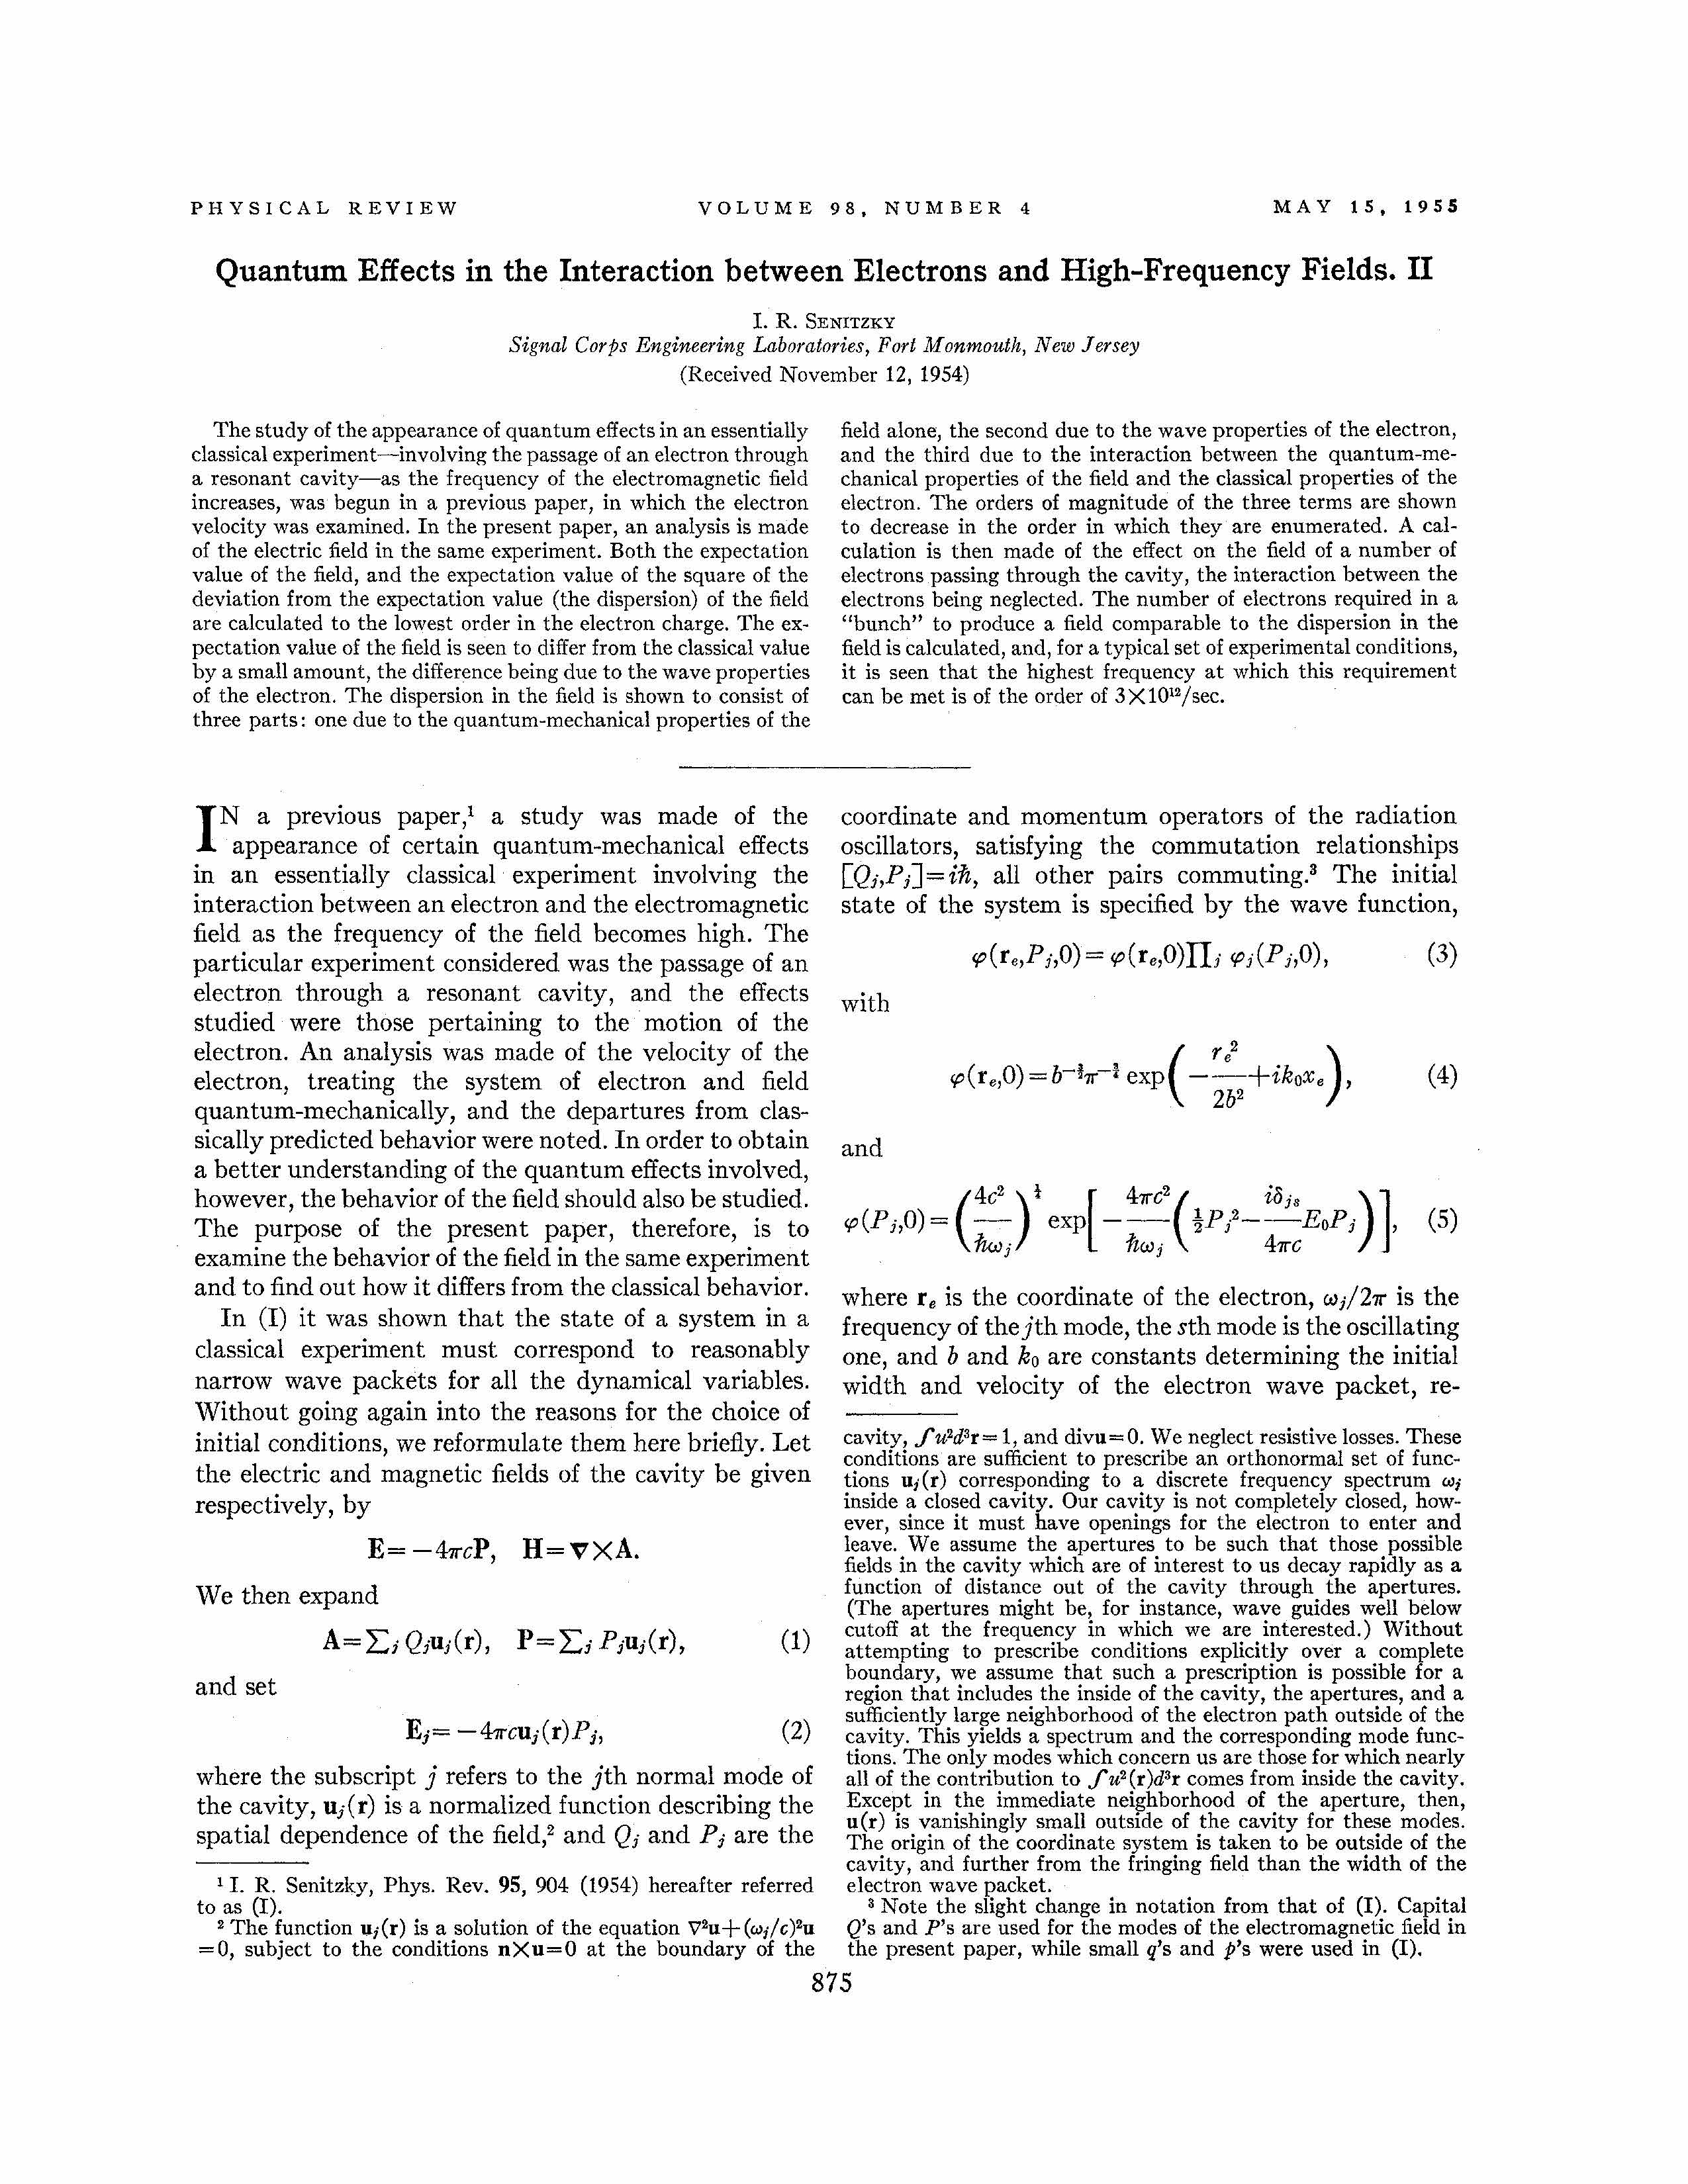

In [44]:
from IPython.display import Image
Image("../data/PhysRev.98.875.jpg", width=1000, height=1000)

Now let's go the other way around and find words most similar to this document:

In [46]:
apsD2V.wv.most_similar( [ apsD2V.docvecs['10.1103/PhysRev.98.875'] ], topn=5) 

[('rf', 0.6460707783699036),
 ('reversing', 0.6440048217773438),
 ('external', 0.6439962387084961),
 ('dc', 0.6165541410446167),
 ('radio', 0.6043131947517395)]

We can even look for documents most like a query composed of multiple words:

In [47]:
apsD2V.docvecs.most_similar([ apsD2V['electron']+apsD2V['positron']+apsD2V['neutron']], topn=5 )

[('10.1103/PhysRev.113.1545', 0.5348371267318726),
 ('10.1103/PhysRev.87.1032', 0.5052643418312073),
 ('10.1103/PhysRev.109.1892', 0.4721039831638336),
 ('10.1103/PhysRev.108.809', 0.4712762236595154),
 ('10.1103/PhysRev.109.2092', 0.46808353066444397)]

Now let's plot some words and documents against one another with a heatmap:

In [48]:
heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)

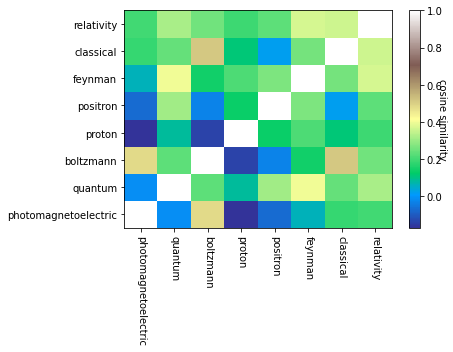

In [49]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)

Now let's look at a heatmap of similarities between the first ten documents in the corpus:

In [50]:
targetDocs = apsDF['doi'][:10]

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

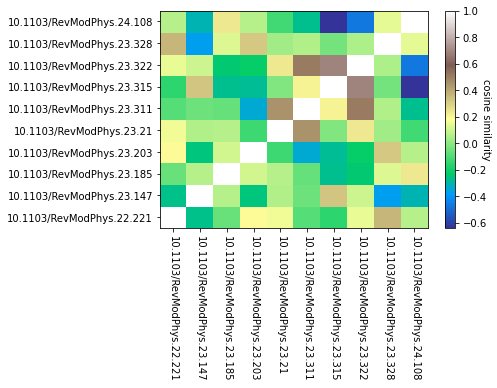

In [51]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

Now let's look at a heatmap of similarities between the first ten documents and our keywords:

In [52]:
heatmapMatrixC = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixC.append(column)
heatmapMatrixC = np.array(heatmapMatrixC)

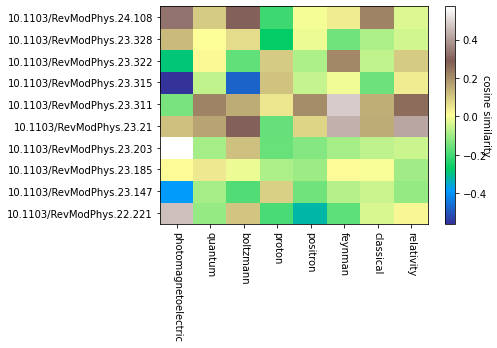

In [53]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixC, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixC.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixC.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

We will save the model in case we would like to use it again.

In [54]:
apsD2V.save('apsW2V')

We can later load it:

In [55]:
#apsD2V = gensim.models.word2vec.Word2Vec.load('data/apsW2V')

## <font color="red">*Exercise 2*</font>

<font color="red">Construct cells immediately below this that embed documents related to your final project using `doc2vec`, and explore the relationship between different documents and the word vectors you analyzed in the last exercise. Consider the most similar words to critical documents, analogies (doc _x_ + word _y_), and other additions and subtractions that reveal the structure of similarity and difference within your semantic space. What does this pattern reveal about the documentary organization of your semantic space?

In [144]:
from gensim.models.doc2vec import TaggedDocument
import gensim

# # Convert the 'normalized_tokens' into TaggedDocuments
# tagged_docs = [TaggedDocument(words=row['normalized_tokens'], tags=[index]) for index, row in merged_df.iterrows()]

# # Build the Doc2Vec model
# d2v_healthW2V = gensim.healthW2Vs.doc2vec.Doc2Vec(tagged_docs, vector_size=100, window=5, min_count=2, workers=4, epochs=20)

# # Train the Doc2Vec model
# d2v_model.train(tagged_docs, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)

# Save the model to disk
#d2v_model.save('/data/model.d2v')

# infer a vector for any document as follows
# vector = d2v_model.infer_vector(["word1", "word2", "word3", ...])

#with keyword

from gensim.models.doc2vec import TaggedDocument
import gensim

# Define keywords
keywords = ['telehealth', 'ai', 'covid', 'disease', 'nlp', 'change']

# Function to assign tags based on keywords and the index of the document
def assign_tags(row, index, keywords):
    tags = [str(index)]  # Start with a unique identifier, such as the index
    # Add keywords present in the document to the tags
    tags.extend([keyword for keyword in keywords if keyword in row['normalized_tokens']])
    return tags

# Convert the 'normalized_tokens' into TaggedDocuments with keywords as tags
tagged_docs = [TaggedDocument(words=row['normalized_tokens'], tags=assign_tags(row, index, keywords)) for index, row in merged_df.iterrows()]

# Build the Doc2Vec model
d2v_model = gensim.models.doc2vec.Doc2Vec(vector_size=100, window=5, min_count=2, workers=4, epochs=20)

# Build the vocabulary
d2v_model.build_vocab(tagged_docs)

# Train the Doc2Vec model
d2v_model.train(tagged_docs, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)

# Save the model for later use
d2v_model.save("d2v_model_with_keywords.model")



In [145]:
d2v_model['telehealth']

array([ 0.48537475, -0.09570203,  0.6647876 , -0.08832794, -0.57468736,
       -1.0177666 ,  1.5348908 , -0.70746857,  0.4570936 , -0.232684  ,
       -0.5457804 ,  0.08146928,  1.4768463 , -1.0860698 ,  0.5451437 ,
       -0.3725763 , -0.9882173 , -0.26179197,  1.8117759 , -1.38592   ,
       -0.79288554, -1.7413689 ,  0.24075153,  0.5177367 , -1.1006329 ,
       -0.21508692,  0.370485  ,  1.4295906 , -0.01475469,  1.60089   ,
       -0.5723232 , -1.5705333 ,  1.0207013 , -1.1363878 , -1.2028507 ,
        1.283478  ,  0.19054136,  0.9201942 ,  0.3198207 ,  0.79197514,
       -0.05683906,  0.8171959 ,  0.9176121 , -0.51520944,  0.50986755,
        0.2525585 , -0.07560004, -0.51828265, -0.5182462 , -0.11390902,
        2.4614751 , -0.5234569 , -1.5805888 ,  0.97588503,  1.2668713 ,
        0.15947954,  1.2894174 , -0.37741277,  0.9122869 ,  0.89217716,
       -0.47689804, -1.3440028 , -0.91518307,  0.86663496,  0.29901934,
        1.532391  , -0.09778039, -0.84077764,  0.20106807, -0.61

In [146]:
d2v_model.wv.most_similar(positive = ['telehealth','ai'], negative = ['covid'], topn = 1)

[('teledentistry', 0.5590896606445312)]

In [147]:
d2v_model.docvecs.most_similar([d2v_model['ai'] ], topn=5 )

[('ai', 0.7125896215438843),
 ('nlp', 0.5795580148696899),
 ('24448', 0.4502812623977661),
 ('16262', 0.44957435131073),
 ('13282', 0.4472748935222626)]

In [148]:
d2v_model.wv.most_similar( [d2v_model.docvecs[21934] ], topn=5) 

[('nuggmd', 0.5591217279434204),
 ('teleleaf', 0.5104343295097351),
 ('mmj', 0.4994868040084839),
 ('anadian', 0.49157679080963135),
 ('smokable', 0.48812809586524963)]

In [149]:
d2v_model.docvecs.most_similar([ d2v_model['doctor']+d2v_model['ai']+d2v_model['covid']], topn=5 )

[('ai', 0.47229689359664917),
 ('1208', 0.4629227817058563),
 ('14975', 0.4533717930316925),
 ('5780', 0.44961705803871155),
 ('4989', 0.44485992193222046)]

In [154]:
keywords = ['telehealth', 'ai', 'covid', 'disease', 'nlp', 'change']
heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = d2v_model.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, d2v_model.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)

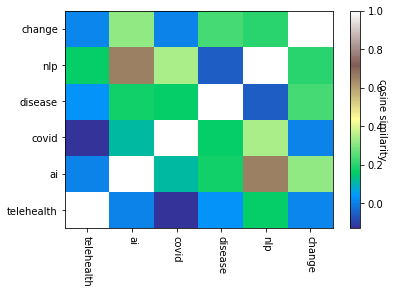

In [155]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)

In [161]:
from gensim.models.doc2vec import TaggedDocument
import gensim


# this is a d2v model with both keywords and_websites
# Function to assign tags based on keywords, website and the index of the document
def assign_tags(row, index, keywords):
    tags = [str(index)]  # Start with a unique identifier, such as the index
    # Add the website name as a tag
    tags.append(row['website'])
    # Add keywords present in the document to the tags
    tags.extend([keyword for keyword in keywords if keyword in row['normalized_tokens']])
    return tags

# Convert the 'normalized_tokens' into TaggedDocuments with keywords and website names as tags
tagged_docs = [TaggedDocument(words=row['normalized_tokens'], tags=assign_tags(row, index, keywords)) for index, row in merged_df.iterrows()]

# Build the Doc2Vec model
d2v_model = gensim.models.doc2vec.Doc2Vec(vector_size=100, window=5, min_count=2, workers=4, epochs=20)

# Build the vocabulary
d2v_model.build_vocab(tagged_docs)

# Train the Doc2Vec model
d2v_model.train(tagged_docs, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)

# Save the model for later use
d2v_model.save("d2v_model_with_keywords_and_websites.model")


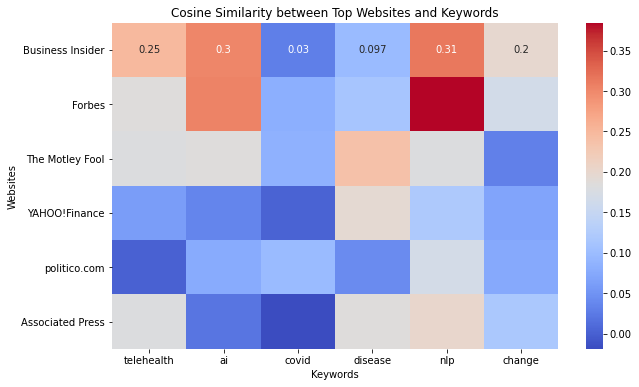

In [162]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Get the counts of each website
website_counts = merged_df['website'].value_counts()

# Identify the top 6 websites
top_websites = website_counts.nlargest(6).index.tolist()

# Keywords to compare
keywords = ['telehealth', 'ai', 'covid', 'disease', 'nlp', 'change']

# Initialize an empty matrix for storing cosine similarities
cosine_matrix = pd.DataFrame(index=top_websites, columns=keywords)

# Calculate cosine similarity for the top websites and keywords
for website in top_websites:
    for keyword in keywords:
        if keyword in d2v_model.wv:
            # Assuming you can get the vector for a website as follows
            website_vector = d2v_model.docvecs[website]  # or use any appropriate method to get the vector
            keyword_vector = d2v_model.wv[keyword]
            cosine_matrix.at[website, keyword] = cosine_similarity([website_vector], [keyword_vector])[0][0]

# Replace NaN values with 0 or appropriate value
cosine_matrix = cosine_matrix.fillna(0)

# Convert matrix values to numeric
cosine_matrix = cosine_matrix.apply(pd.to_numeric)

# Plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cosine_matrix, annot=True, cmap='coolwarm')
plt.title('Cosine Similarity between Top Websites and Keywords')
plt.ylabel('Websites')
plt.xlabel('Keywords')
plt.show()


From the first heatmap (PCA Visualization of Word Vectors and t-SNE Visualization of Word Vectors), it's evident that certain words are clustered together, indicating that they occur in similar contexts within the corpus. 

The second heatmap (Cosine Similarity between Top Websites and Keywords) shows how each website relates to the set of keywords based on their document vectors. For example, if the 'telehealth' keyword has a high cosine similarity with 'Business Insider', it suggests that 'Business Insider' contains content or context that is closely related to 'telehealth'. Similarly, a low similarity score would indicate less relevance or discussion about that keyword on the website.

The pattern revealed by these visualizations suggests that there is a definable structure to how different concepts are discussed and related to each other within the corpus. It reflects the semantic associations between words as they are used across different documents, which can be indicative of the overall themes and discussions prevalent in the corpus.

# Projection

We can also project word vectors to an arbitray semantic dimension. To demonstrate this possibility, let's first load a model trained with New York Times news articles. 

In [56]:
nytimes_model = gensim.models.KeyedVectors.load_word2vec_format('../data/nytimes_cbow.reduced.txt')

First we can visualize with dimension reduction

In [57]:
#words to create dimensions
tnytTargetWords = ['man','him','he', 'woman', 'her', 'she', 'black','blacks','African', 'white', 'whites', 'Caucasian', 'rich', 'richer', 'richest', 'expensive', 'wealthy', 'poor', 'poorer', 'poorest', 'cheap', 'inexpensive']
#words we will be mapping
tnytTargetWords += ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse", "steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry", "basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]


wordsSubMatrix = []
for word in tnytTargetWords:
    wordsSubMatrix.append(nytimes_model[word])
wordsSubMatrix = np.array(wordsSubMatrix)
#wordsSubMatrix

In [58]:
pcaWordsNYT = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_dataNYT = pcaWordsNYT.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWordsNYT = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_dataNYT)

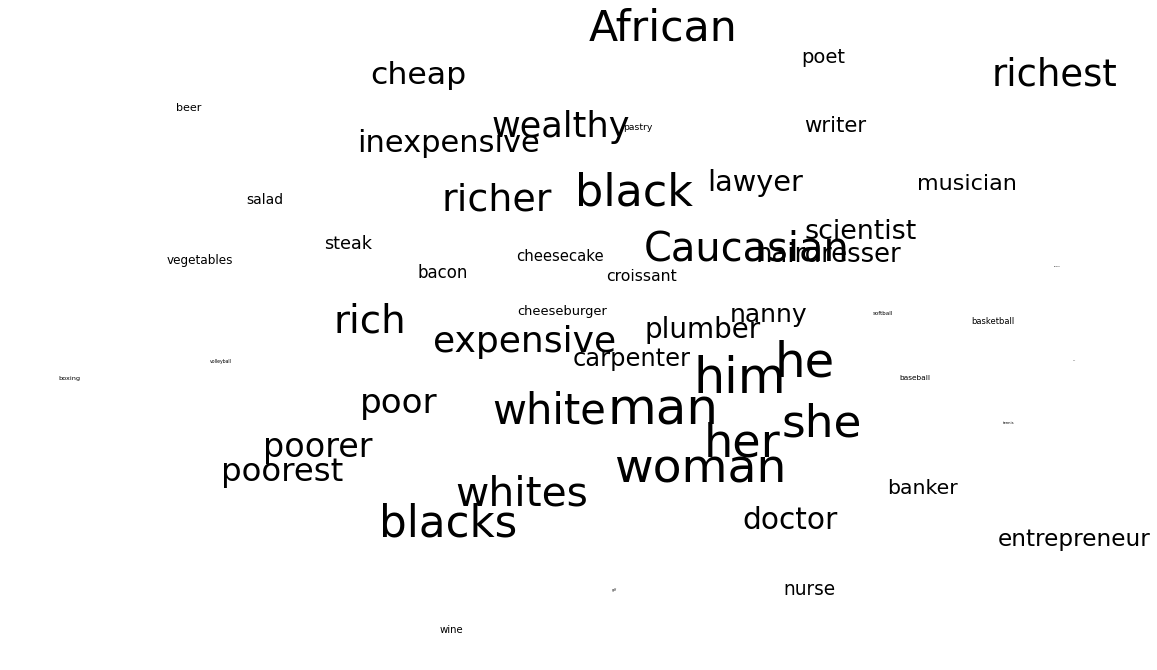

In [59]:
fig = plt.figure(figsize = (20,12))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWordsNYT[:, 0], tsneWordsNYT[:, 1], alpha = 0) #Making the points invisible
for i, word in enumerate(tnytTargetWords):
    ax.annotate(word, (tsneWordsNYT[:, 0][i],tsneWordsNYT[:, 1][i]), size =  50 * (len(tnytTargetWords) - i) / len(tnytTargetWords))
plt.xticks(())
plt.yticks(())
plt.show()

Define some convenient functions for getting dimensions. 

In [183]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

# def dimension(model, positives, negatives):
#     diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
#     return diff

def dimension(model, positives, *negatives):
    positive_sum = sum([normalize(model.wv[x]) for x in positives])
    negative_sum = sum([sum([normalize(model.wv[y]) for y in neg_list]) for neg_list in negatives])
    return positive_sum - negative_sum

Let's calculate three dimensions: gender, race, and class.

In [61]:
Gender = dimension(nytimes_model, ['man','him','he'], ['woman', 'her', 'she'])
Race = dimension(nytimes_model, ['black','blacks','African'], ['white', 'whites', 'Caucasian'])
Class = dimension(nytimes_model, ['rich', 'richer', 'richest', 'expensive', 'wealthy'], ['poor', 'poorer', 'poorest', 'cheap', 'inexpensive'])

Here we have some words.

In [62]:
Occupations = ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse"]

Foods = ["steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry"]

Sports  = ["basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]

Define a function to project words in a word list to each of the three dimensions.

In [198]:
def makeDF(model, word_list):
    g = []
    r = []
    c = []
    for word in word_list:
        g.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), Gender.reshape(1,-1))[0][0])
        r.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), Race.reshape(1,-1))[0][0])
        c.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), Class.reshape(1,-1))[0][0])
    df = pd.DataFrame({'gender': g, 'race': r, 'class': c}, index = word_list)
    return df

Get the projections.

In [64]:
OCCdf = makeDF(nytimes_model, Occupations) 
Fooddf = makeDF(nytimes_model, Foods)
Sportsdf = makeDF(nytimes_model, Sports)

Define some useful functions for plotting.

In [200]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

Plot the occupational words in each of the three dimensions.

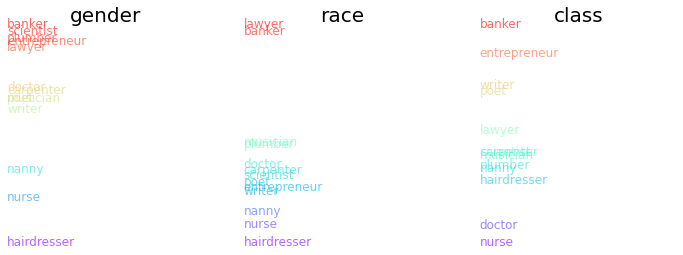

In [66]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, OCCdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, OCCdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, OCCdf, 'class')
plt.show()

Foods:

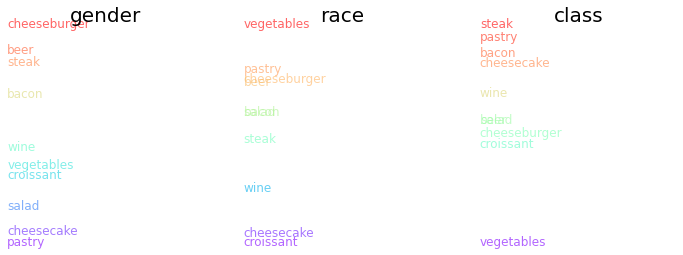

In [67]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Fooddf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Fooddf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Fooddf, 'class')
plt.show()

Sports:

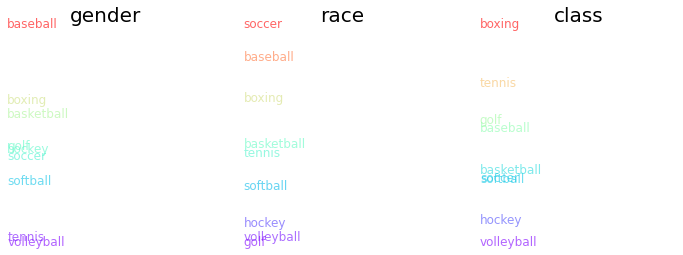

In [68]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Sportsdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Sportsdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Sportsdf, 'class')
plt.show()

## <font color="red">*Exercise 3*</font>

<font color="red">Construct cells immediately below this that embed documents related to your final project, then generate meaningful semantic dimensions based on your theoretical understanding of the semantic space (i.e., by subtracting semantically opposite word vectors) and project another set of word vectors onto those dimensions. Interpret the meaning of these projections for your analysis. Which of the dimensions you analyze explain the most variation in the projection of your words and why? 

<font color="red">***Stretch***: Average together multiple antonym pairs to create robust semantic dimensions. How do word projections on these robust dimensions differ from single-pair dimensions?

In [172]:
#words to create dimensions
healthTargetWords = ['male','he','female', 'she', 'black', 'white','asian','rich', 'expensive', 'wealthy', 'poor', 'poorer', 'cheap', 'inexpensive']
#words we will be mapping
healthTargetWords += ["doctor","telehealth","telemedicine","healthcare","change","easy","hard","difficult","hate","trend","ai"]


wordsSubMatrix = []
for word in healthTargetWords:
    wordsSubMatrix.append(healthW2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)
#wordsSubMatrix

In [177]:
pcaWordshealth = sklearn.decomposition.PCA(n_components = 25).fit(wordsSubMatrix)
reducedPCA_datahealth = pcaWordshealth.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWordshealth = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_datahealth)

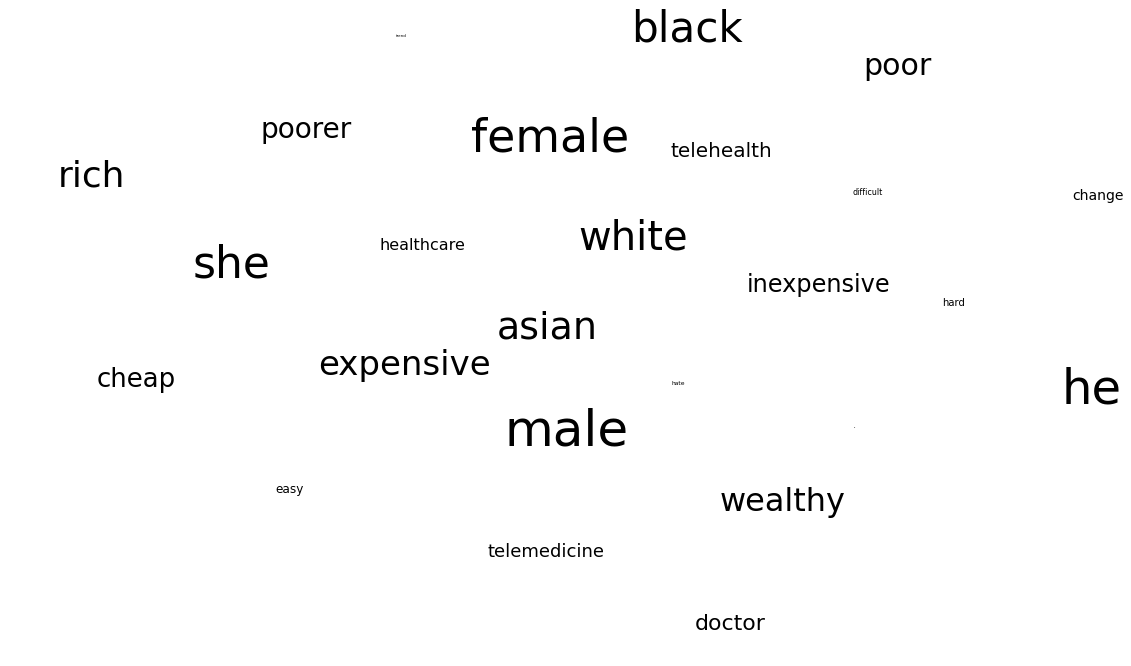

In [179]:
fig = plt.figure(figsize = (20,12))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWordshealth[:, 0], tsneWordshealth[:, 1], alpha = 0) #Making the points invisible
for i, word in enumerate(healthTargetWords):
    ax.annotate(word, (tsneWordshealth[:, 0][i],tsneWordshealth[:, 1][i]), size =  50 * (len(healthTargetWords) - i) / len(healthTargetWords))
plt.xticks(())
plt.yticks(())
plt.show()

In [191]:
Gender = dimension(healthW2V, ['man','him','he','male'], ['woman', 'she','female'])
Race = dimension(healthW2V, ['black'], ['white'],['asian',"aapi"])
Class = dimension(healthW2V, ['rich', 'expensive', 'wealthy'], ['poor', 'poorer', 'cheap', 'inexpensive'])

In [206]:
Telehealth = ["telehealth","telemedicine","healthcare","telepsychiatry","virtual", "remote","teleconsultation"]

Hospital = ["hospital", "icu", "inpatient", "ward", "facility", "emergency"]

Disease  = ["covid", "covid19", "flu", "softball", "syndrome", "disease", "heart", "mental", "depression","lung","cancer"]


In [207]:
Teledf = makeDF(healthW2V, Telehealth) 
Hospitaldf = makeDF(healthW2V, Hospital)
Diseasedf = makeDF(healthW2V, Disease)

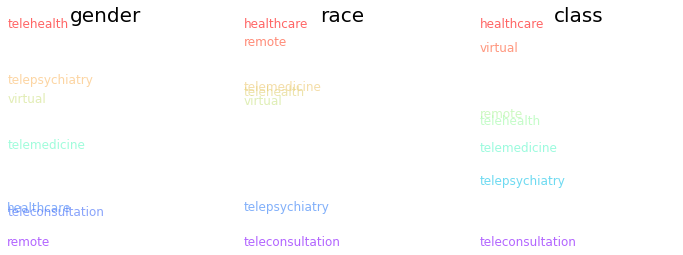

In [202]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Teledf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Teledf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Teledf, 'class')
plt.show()

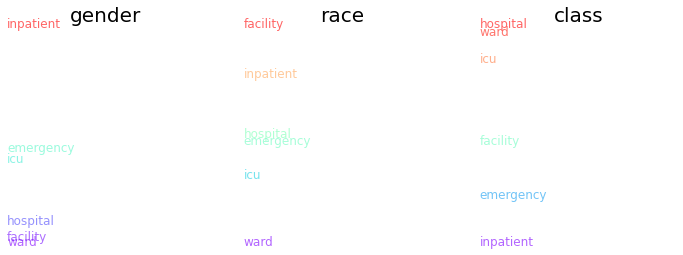

In [205]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Hospitaldf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Hospitaldf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Hospitaldf, 'class')
plt.show()

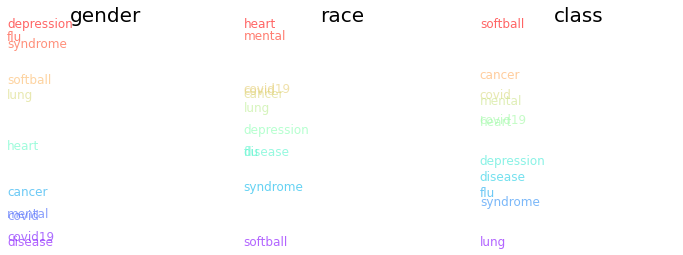

In [208]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Diseasedf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Diseasedf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Diseasedf, 'class')
plt.show()

The words closest to each axis in the visualizations suggest a strong association with that dimension in the corpus.  

**Telehealth visualization:**
- terms like "telepsychiatry," "telemedicine," and "teleconsultation" may be closely related to the gender dimension within discussions of telehealth services, indicating a possible gendered aspect to the discussion or usage of these services. 

**Hospital Visualization:**
- **Gender Axis:** Terms like "inpatient" and "emergency" appear in proximity to the gender axis, which may suggest that discussions or reports around these terms are gendered in nature. It could imply that the topics of inpatient services and emergencies are frequently discussed with reference to gender differences, perhaps in terms of healthcare outcomes, access, or needs.
- **Race Axis:** The words "facility," "ward," and "hospital" are close to the race dimension. This could reflect a racial context in the way these terms are used within the corpus. There could be a focus on racial disparities in hospital services or differences in the quality of facilities available to different racial groups.
- **Class Axis:** The presence of terms like "hospital" and "inpatient" near the class dimension may indicate that economic factors are an important aspect of discussions around hospital services. Class differences might play a significant role in determining the kind of hospital care or facilities one has access to.

**Disease Visualization:**
- **Gender Axis:** The visualization might show terms like "depression" and "syndrome" aligned with gender, hinting at a potential focus on gender-specific diseases or how certain diseases are perceived differently when affecting different genders.
- **Race Axis:** Words such as "mental" and "covid" near the race axis could be indicative of a discussion that highlights racial disparities in mental health or the impact of COVID-19 on different racial groups.
- **Class Axis:** The positioning of "covid" near the class axis might reflect discussions around how socioeconomic status affects the spread, treatment, and impact of diseases like COVID-19. It could also point to the socioeconomic consequences of the pandemic.

Similarly, words clustered around the "race" dimension could indicate a racial aspect in the context of telehealth, perhaps reflecting demographic disparities in access or the focus of certain discussions.
The "class" dimension is also telling, with terms like "virtual" and "healthcare" appearing close to it, possibly suggesting an association between class and access to virtual healthcare services.

In all visualizations, the distribution and clustering of words around these dimensions can reveal how societal factors intersect with healthcare topics. They highlight the complexity and multidimensionality of healthcare-related discussions, where factors such as gender, race, and class significantly influence the conversation. These patterns can offer insights into the structural inequalities and biases present in the healthcare system and can inform policymakers, healthcare providers, and researchers about areas that may require targeted interventions or further study.





In [210]:
import numpy as np
from gensim.models import Word2Vec

# and a list of words to project named 'words_to_project'

# Define antonym pairs
antonym_pairs = [
    ('easy', 'difficult'),
    ('rich', 'poor'),
    ('expensive', 'cheap')
    # Add more as needed
]

# Function to normalize vectors
def normalize(vector):
    return vector / np.linalg.norm(vector)

# Function to compute dimension vectors from antonym pairs
def compute_dimension(healthW2V, positive, negative):
    return normalize(healthW2V.wv[positive] - healthW2V.wv[negative])

# Create robust dimensions by averaging dimension vectors
robust_dimensions = []
for positive, negative in antonym_pairs:
    dimension_vector = compute_dimension(healthW2V, positive, negative)
    robust_dimensions.append(dimension_vector)
average_dimension = np.mean(robust_dimensions, axis=0)

# Project words onto the average robust dimension
word_projections = {}
for word in Telehealth:
    if word in healthW2V.wv:
        word_vector = normalize(healthW2V.wv[word])
        projection = np.dot(word_vector, average_dimension)
        word_projections[word] = projection

# Compare projections with a single-pair dimension
single_dimension = compute_dimension(healthW2V, 'happy', 'sad')
single_projections = {}
for word in Telehealth:
    if word in healthW2V.wv:
        word_vector = normalize(healthW2V.wv[word])
        projection = np.dot(word_vector, single_dimension)
        single_projections[word] = projection


In [212]:
# Now compare the values in word_projections with single_projections to see how the words align differently 
# along the robust dimension versus the single-pair dimension.

# Function to compare projections
def compare_projections(word_projections, single_projections):
    comparison_dict = {}
    for word in word_projections:
        robust_proj = word_projections[word]
        single_proj = single_projections[word]
        comparison_dict[word] = {
            'Robust Dimension Projection': robust_proj,
            'Single-pair Dimension Projection': single_proj,
            'Difference': robust_proj - single_proj
        }
    return comparison_dict

# Now use the function to compare the projections
comparison = compare_projections(word_projections, single_projections)

# Sort words by the difference in their projections along the two dimensions
sorted_comparison = sorted(comparison.items(), key=lambda item: item[1]['Difference'], reverse=True)

# Print out the sorted comparison
for word, projections in sorted_comparison:
    print(f"{word}: Robust - {projections['Robust Dimension Projection']:.3f}, "
          f"Single - {projections['Single-pair Dimension Projection']:.3f}, "
          f"Diff - {projections['Difference']:.3f}")


telepsychiatry: Robust - 0.025, Single - 0.043, Diff - -0.018
virtual: Robust - 0.072, Single - 0.104, Diff - -0.032
telemedicine: Robust - 0.032, Single - 0.093, Diff - -0.060
healthcare: Robust - 0.036, Single - 0.110, Diff - -0.074
telehealth: Robust - 0.011, Single - 0.095, Diff - -0.085
teleconsultation: Robust - 0.045, Single - 0.151, Diff - -0.106
remote: Robust - -0.006, Single - 0.180, Diff - -0.186


The results suggest that each word's semantic association with the concepts defined by the single-pair dimension is stronger than with the robust dimension(created by averaging multiple antonym pairs), which is intended to provide a more nuanced and balanced semantic axis. On the other hand, the single-pair dimension is based on a single set of antonyms, which may represent a more extreme or less nuanced position on the semantic axis.

- **telepsychiatry**: This word is relatively close in projection on both dimensions, but its association is slightly weaker on the robust dimension. This might indicate that telepsychiatry is a specialized field within telehealth that does not vary greatly with the introduction of additional context.
  
- **virtual**: The difference in projection is more pronounced for "virtual," suggesting that while it is a general term applicable to many contexts, its specific meaning becomes less focused when considering a broader range of antonyms.

- **telemedicine**: There is a significant difference in projections, with a much weaker association on the robust dimension. This implies that "telemedicine" may have a broad semantic range that becomes less specific when averaged over multiple dimensions.

- **healthcare**: A large drop in projection on the robust dimension suggests that "healthcare" as a term might be more broadly related to the single-pair antonyms, and this relationship becomes diluted when averaged with other antonym pairs.

- **telehealth**: Shows the largest drop in projection, indicating that the specific context given by the single-pair antonyms is crucial to its semantic understanding, and this becomes much less defined in the robust dimension.

- **teleconsultation**: Like "telehealth," the significant difference indicates that "teleconsultation" is semantically much closer to the single-pair dimension, and the broader context of the robust dimension diminishes this association.

- **remote**: The negative robust projection suggests that "remote" may actually be semantically opposed to the concept represented by the robust dimension, or at least unrelated. The significant positive projection in the single-pair dimension indicates a strong association that is not captured by the robust dimension.

Overall, these results suggest that the semantic space related to telehealth and associated terms is complex and cannot be fully captured by a single semantic dimension.

# The Score Function

The score function is a simple calculation developed by [Matt Taddy](https://arxiv.org/pdf/1504.07295.pdf) to calculate the likelihood that a given text would have been generated by a word-embedding model by summing the inner product between each pair of the text's word vectors. This relies on a few data files that are not in the git repo due to their size please download and unzip [this](https://github.com/Computational-Content-Analysis-2018/Upcoming/raw/master/data/supplement.zip) (472MB) file in the data directory.

Here, we explore this using a model trained with millions of resumes from the CareerBuilder website (we can't share the private resumes...but we can share a model built with them :-):

In [ ]:
# Below code does not work, genism 3.8.3, tried serveral word2vec loading method,
# but always get AttributeError: 'Word2Vec' object has no attribute 'wv' 

#from gensim.models import Word2Vec
#resume_model = Word2Vec.load('../data/resumeAll.model')

We can examine the vacabularies of this model by building a word-index map:

In [ ]:
vocab = resume_model.wv.index2word

Let's just load the sample and take a look at it. The sentences in each job description are already tokenized and normalized.

In [21]:
sampleDF = pd.read_csv('../data/SampleJobAds.csv', index_col = False)
#We need to convert the last couple columns from strings to lists
sampleDF['tokenized_sents'] = sampleDF['tokenized_sents'].apply(lambda x: eval(x))
sampleDF['normalized_sents'] = sampleDF['normalized_sents'].apply(lambda x: eval(x))
sampleDF

,Unnamed: 0,hiringOrganization_organizationName,jobDescription,jobLocation_address_region,jobLocation_geo_latitude,jobLocation_geo_longitude,qualifications,responsibilities,tokenized_sents,normalized_sents
0,158844,"Golfsmith International, Inc.","""Sales Associate Tracking Code 220425-971 Job ...",California,33.91918,-118.41647,NaN,"""Ensure each Customer receives exceptional ser...","[[``, Sales, Associate, Tracking, Code, 220425...","[[sales, associate, tracking, code, job, descr..."
1,257645,Intel,For PHY system engineering team within the Wir...,NaN,NaN,NaN,NaN,NaN,"[[For, PHY, system, engineering, team, within,...","[[for, phy, system, engineering, team, within,..."
2,107875,Florida Hospital,*RN Medical Oncology PCU Orlando - Nights* Flo...,Florida,28.53834,-81.37924,NaN,NaN,"[[*RN, Medical, Oncology, PCU, Orlando, -, Nig...","[[medical, oncology, pcu, orlando, florida, ho..."
3,202394,Hitachi Data Systems,Title: Specialist Sales Account Representative...,NaN,NaN,NaN,NaN,NaN,"[[Title, :, Specialist, Sales, Account, Repres...","[[title, specialist, sales, account, represent..."
4,109675,Footprint Retail Services,**Footprint Retail Services** **Job Descriptio...,NaN,NaN,NaN,NaN,A Merchandiser must complete all assigned merc...,"[[**Footprint, Retail, Services**, **Job, Desc...","[[retail, job, title, retail, merchandiser, re..."
...,...,...,...,...,...,...,...,...,...,...
95,157791,Golden Living,"Here at Golden LivingCenters, we rely on and t...",Nebraska,40.67667,-95.85917,High school diploma or equivalent;Must within ...,NaN,"[[Here, at, Golden, LivingCenters, ,, we, rely...","[[here, at, golden, livingcenters, we, rely, o..."
96,119835,GameStop,"""*Description* Description: SUMMARY At GameSto...",New York,40.68149,-73.39984,NaN,NaN,"[[``, *Description*, Description, :, SUMMARY, ...","[[description, summary, at, gamestop, we, refe..."
97,285609,Jewel-Osco,"""Updated 6/2011 JOB TITLE: Service Clerk (Bagg...",Illinois,41.66892,-87.73866,NaN,"Provides prompt, efficient and friendly custom...","[[``, Updated, 6/2011, JOB, TITLE, :, Service,...","[[updated, job, title, service, clerk, bagger,..."
98,89260,Express Scripts,"""Schedule: Full-time Job ID: 1500071I The Sale...",Missouri,38.62727,-90.19789,NaN,o Proactive management of Houston entry & comp...,"[[``, Schedule, :, Full-time, Job, ID, :, 1500...","[[schedule, job, id, the, sales, coordinator, ..."


Let's define a function to calculate the likelihood of each job description. The idea is borrowed from [Matt Taddy](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/deepir.ipynb), who shows how a document can be characterized as the inner product of the distance between its words. In other words, this analysis will show which job ads are most likely to find an appropriate pool of workers in the resume bank that generated our word embedding.  

In [22]:
def adprob(ad, model):
    sen_scores = model.score(ad, len(ad))
    ad_score = sen_scores.mean()
    return ad_score

Let's apply this function to every job description.

In [ ]:
sampleDF['likelihood'] = sampleDF['normalized_sents'].apply(lambda x: adprob(x, resume_model))

Let's take a look at the top 5 job descriptions that have the highest likelihood.

In [ ]:
for ad in sampleDF.sort_values(by = 'likelihood', ascending = False)['jobDescription'][:5]:
    print (ad + '\n\n')

Let's take a look at the bottom 5 job descriptions that have the lowest likelihood to be matched by the resumes.

In [ ]:
for ad in sampleDF.sort_values(by = 'likelihood')['jobDescription'][:5]:
    print (ad + '\n\n')

We can do the same for phrases corresponding to job skills.

In [ ]:
adprob([["python", "programming"]], resume_model)

In [ ]:
adprob([["julia", "programming"]], resume_model)

Basic programming appears to be more likely in this pool of resumes than python programming. 

We can also do some simple statistics. Unfortunately, we don't have a large sample here. Nevertheless, let's first look at the mean likelihood score of each hiring organization. Some organizations will do well to hire on CareerBuilder...while others will not.

In [ ]:
sampleDF.groupby("hiringOrganization_organizationName")[['likelihood']].mean().sort_values('likelihood', ascending = False)

We can also look at the mean likelihood of each state.

In [ ]:
sampleDF.groupby("jobLocation_address_region")[['likelihood']].mean().sort_values('likelihood', ascending = False)

You would increase the sample size if you want to do a more serious study.

## <font color="red">*Exercise 4a*</font>

<font color="red">**Do only 4a or 4b.** Construct cells immediately below this that calculate the scores for a small sample of documents from outside your corpus to identify which are closest to your corpus. Then calculate the scores for a few phrases or sentences to identify the ones most likely to have appeared in your corpus. Interrogate patterns associated with these document/phrase scores (e.g., which companies produced job ads most or least likely to find jobseekers in the resume corpus?) What do these patterns suggest about the boundaries of your corpus?

* I have done 4b below

# Linguistic Change or Difference

Below is code that aligns the dimensions of multiple embeddings arrayed over time or some other dimension and allow identification of semantic chanage as the word vectors change their loadings for focal words. This code comes from the approach piloted at Stanford by William Hamilton, Daniel Jurafsky and Jure Lescovec [here](https://arxiv.org/pdf/1605.09096.pdf). 

In [30]:
import copy

In [121]:
def calc_syn0norm(model):
    """since syn0norm is now depricated"""
    return (model.wv.syn0 / np.sqrt((model.wv.syn0 ** 2).sum(-1))[..., np.newaxis]).astype(np.float32)

def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
    (With help from William. Thank you!)
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """
    base_embed = copy.copy(base_embed)
    other_embed = copy.copy(other_embed)
    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # get the embedding matrices
    # base_vecs = calc_syn0norm(in_base_embed)
    # other_vecs = calc_syn0norm(in_other_embed)
    base_vecs= [in_base_embed.wv.get_vector(w,norm=True) for w in set(in_base_embed.wv.index_to_key)]
    other_vecs= [in_other_embed.wv.get_vector(w,norm=True) for w in set(in_other_embed.wv.index_to_key)]

    # just a matrix dot product with numpy
    m = np.array(other_vecs).T.dot(np.array(base_vecs))
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v)
    # Replace original array with modified one
    # i.e. multiplying the embedding matrix (syn0norm)by "ortho"
    other_embed.wv.vectors =(np.array(other_vecs)).dot(ortho)
    return other_embed

def intersection_align_gensim(m1,m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.index_to_key)
    vocab_m2 = set(m2.wv.index_to_key)

    # Find the common vocabulary
    common_vocab = vocab_m1&vocab_m2
    if words: common_vocab&=set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1-common_vocab and not vocab_m2-common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.get_vecattr(w, "count")  + m2.wv.get_vecattr(w, "count") ,reverse=True)

    # Then for each model...
    for m in [m1,m2]:
        # Replace old syn0norm array with new one (with common vocab)
        new_arr = [m.wv.get_vector(w,norm=True) for w in common_vocab]

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        m.index2word = common_vocab
        # old_vocab = m.wv.index_to_key
        new_vocab = []
        k2i={}
        for new_index,word in enumerate(common_vocab):
            new_vocab.append(word)
            k2i[word]=new_index
        m.wv.index_to_key=new_vocab
        m.wv.key_to_index=k2i
        m.wv.vectors=np.array(new_arr)

    return (m1,m2)

In order to explore this, let's get some data that follows a time trend. We'll look at conference proceedings from the American Society for Clinical Oncologists.

In [32]:
ascoDF = pd.read_csv("../data/ASCO_abstracts.csv", index_col=0)

Prepare for wor2vec:

In [33]:
ascoDF['tokenized_sents'] = ascoDF['Body'].apply(lambda x: [lucem_illud.word_tokenize(s) for s in lucem_illud.sent_tokenize(x)])
ascoDF['normalized_sents'] = ascoDF['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s) for s in x])

c:\Users\flori\AppData\Local\Programs\Python\Python39\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [34]:
ascoDF

,Year,AbstractCategory,Title,FirstAuthor,Body,AbstractPublicationID,tokenized_sents,normalized_sents
0,1995,Lung Cancer,Treatment of non-small cell lung cancer with c...,GP Stathopoulos,Cisplatin compound is established as the main ...,1181,"[[Cisplatin, compound, is, established, as, th...","[[cisplatin, compound, established, main, drug..."
1,1995,Breast Cancer,Treatment of primary breast cancer without mas...,A Bluming,"Between March 24, 1977, and March 24, 1983, 15...",270,"[[Between, March, 24, 1977, and, March, 24, 19...","[[march, march, women, primary, breast, cancer..."
2,1995,Gynecologic Cancer,Treatment of relapsed ovarian carcinoma with e...,M Metzner,ECF has established activity and a high respon...,784,"[[ECF, has, established, activity, and, a, hig...","[[ecf, established, activity, high, response, ..."
3,1995,Lung Cancer,Treatment of small cell lung cancer (SCLC) wit...,JD Hainsworth,"In 7/93, we began investigation of a three-dru...",1197,"[[In, 7/93, we, began, investigation, of, a, t...","[[began, investigation, drug, combination, pac..."
4,1995,Other Gastrointestinal Cancer,Vaccine-based (active specific) chemoimmunothe...,SH Itzkowitz,Active specific immunotherapy (ASI) is the adm...,549,"[[Active, specific, immunotherapy, ASI, is, th...","[[active, specific, immunotherapy, asi, admini..."
...,...,...,...,...,...,...,...,...
62568,2011,Lung Cancer - Local-Regional and Adjuvant Ther...,Management of thymic epithelial tumors (TETs) ...,A. Rajan,<p><b>Background: </b> TETs are very rare ante...,NaN,"[[<, p><b, >, Background, <, /b, >, TETs, are,...","[[<, p><b, >, background, <, /b, >, tets, rare..."
62576,2011,Patient and Survivor Care,Spinal or epidural analgesia for cancer pain: ...,N. Yarom,<p><b>Background:</b> Cancer pain is occasiona...,NaN,"[[<, p><b, >, Background:</b, >, Cancer, pain,...","[[<, p><b, >, background:</b, >, cancer, pain,..."
62577,2011,Developmental TherapeuticsÑExperimental Therap...,Comparative PARP enzyme inhibition of PF-01367...,K. A. Kern,<p><b>Background:</b> Within the past several ...,NaN,"[[<, p><b, >, Background:</b, >], [Within, the...","[[<, p><b, >, background:</b, >], [past, years..."
62585,2011,Genitourinary Cancer,Risk stratification and stage migration effect...,B. B. Desai,<p><b>Background:</b> To evaluate the diagnost...,NaN,"[[<, p><b, >, Background:</b, >, To, evaluate,...","[[<, p><b, >, background:</b, >, evaluate, dia..."


We will be creating many embeddings so we have created this function to do most of the work. It creates two collections of embeddings, one the original and one the aligned.

In [122]:
def compareModels(df, category, text_column_name='normalized_sents', sort = True, embeddings_raw={}):
    """If you are using time as your category sorting is important"""
    if len(embeddings_raw) == 0:
        embeddings_raw = rawModels(df, category, text_column_name, sort)
    cats = sorted(set(df[category]))
    #These are much quicker
    embeddings_aligned = {}
    for catOuter in cats:
        embeddings_aligned[catOuter] = [embeddings_raw[catOuter]]
        for catInner in cats:
            embeddings_aligned[catOuter].append(smart_procrustes_align_gensim(embeddings_aligned[catOuter][-1], embeddings_raw[catInner]))
    return embeddings_raw, embeddings_aligned

In [123]:
def rawModels(df, category, text_column_name='normalized_sents', sort = True):
    embeddings_raw = {}
    cats = sorted(set(df[category]))
    for cat in cats:
        #This can take a while
        print("Embedding {}".format(cat), end = '\r')
        subsetDF = df[df[category] == cat]
        #You might want to change the W2V parameters
        embeddings_raw[cat] = gensim.models.word2vec.Word2Vec(subsetDF[text_column_name].sum())
    return embeddings_raw

In [124]:
rawEmbeddings, comparedEmbeddings = compareModels(ascoDF, 'Year')

Now we generate the models:

In [125]:
rawEmbeddings.keys()

dict_keys([1995, 1996, 1997, 1998, 1999, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011])

We need to compare them across all permutions so we will define another function to help, we will be using 1 - cosine similarity as that gives a more intitive range of 0-2 with low values meaning little change and high meaning lots of change.

In [128]:
def getDivergenceDF(word, embeddingsDict):
    dists = []
    cats = sorted(set(embeddingsDict.keys()))
    dists = {}
    print(word)
    for cat in cats:
        dists[cat] = []
        for embed in embeddingsDict[cat][1:]:
            dists[cat].append(np.abs(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cat][0].wv[word], axis = 0),
                                                                             np.expand_dims(embed.wv[word], axis = 0))[0,0]))
    return pd.DataFrame(dists, index = cats)

breast


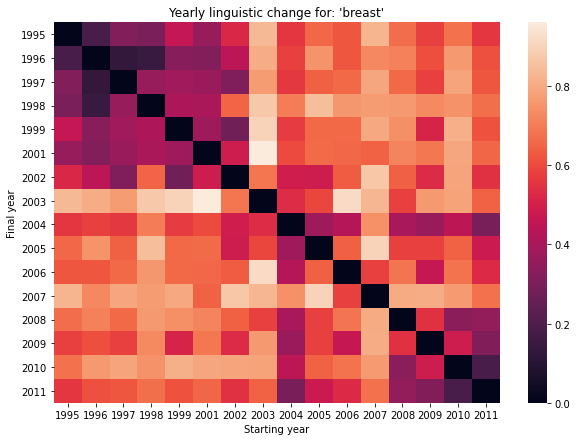

In [129]:
targetWord = 'breast'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

Lets look at a couple words:

combination


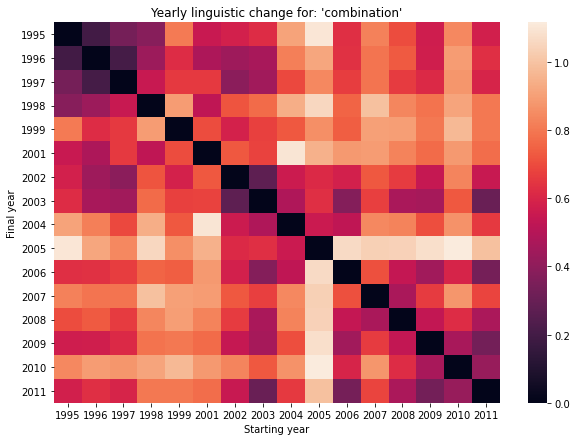

In [130]:
targetWord = 'combination'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()


In [141]:
def findDiverence(word, embeddingsDict):
    cats = sorted(set(embeddingsDict.keys()))

    dists = []
    for embed in embeddingsDict[cats[0]][1:]:
        try:
            dists.append(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cats[0]][0].wv[word], axis = 0), np.expand_dims(embed.wv[word], axis = 0))[0,0])
        except:
            pass
    return np.mean(dists)

def findMostDivergent(embeddingsDict):
    original_words = comparedEmbeddings[1995][0].wv.index_to_key
    for embeds in embeddingsDict.values():
        for embed in embeds:
            original_words = set(original_words).intersection(set(embed.wv.index_to_key))
    words = set(original_words)
    print("Found {} words to compare".format(len(words)))
    return sorted([(w, findDiverence(w, embeddingsDict)) for w in words], key = lambda x: x[1], reverse=True)


In [142]:
wordDivergences = findMostDivergent(comparedEmbeddings)

Found 1790 words to compare


The most divergent words are:

In [143]:
wordDivergences[:20]

[('fever', 0.8894315182697028),
 ('log', 0.8544416115619242),
 ('curative', 0.8475937406765297),
 ('decline', 0.8170867352746427),
 ('additional', 0.8148868710268289),
 ('progressive', 0.81439722146024),
 ('sites', 0.8131347636226565),
 ('peripheral', 0.8116826539044268),
 ('ajcc', 0.8030357981624547),
 ('led', 0.7972429751534946),
 ('needed', 0.7947484004544094),
 ('anderson', 0.7937333107984159),
 ('gemcitabine', 0.7892841113498434),
 ('clinic', 0.7879024817375466),
 ('proteins', 0.78142602002481),
 ('mediated', 0.7797583930660039),
 ('records', 0.7795431624399498),
 ('hours', 0.7757726826239377),
 ('validated', 0.7751274840702536),
 ('gr', 0.7745226711267605)]

And the least:

In [144]:
wordDivergences[-20:]

[('prediction', 0.4642101041972637),
 ('esophagus', 0.4640742652118206),
 ('explained', 0.46231299359351397),
 ('cs', 0.4618041394278407),
 ('measurable', 0.4614762896671891),
 ('effectiveness', 0.461373521015048),
 ('course', 0.4609777182340622),
 ('y', 0.4601751295849681),
 ('pr', 0.45869232062250376),
 ('radiological', 0.45817876514047384),
 ('highly', 0.45780098158866167),
 ('positively', 0.4518456198275089),
 ('exon', 0.44819373916834593),
 ('problems', 0.4473653733730316),
 ('option', 0.44379889219999313),
 ('reports', 0.43865575455129147),
 ('ensure', 0.4327040808275342),
 ('responders', 0.4323502741754055),
 ('different', 0.42752591893076897),
 ('doxorubicin', 0.42486861161887646)]

fever


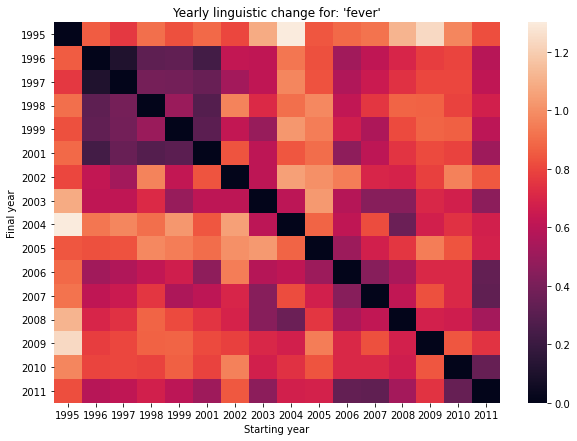

In [145]:
targetWord = wordDivergences[0][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

doxorubicin


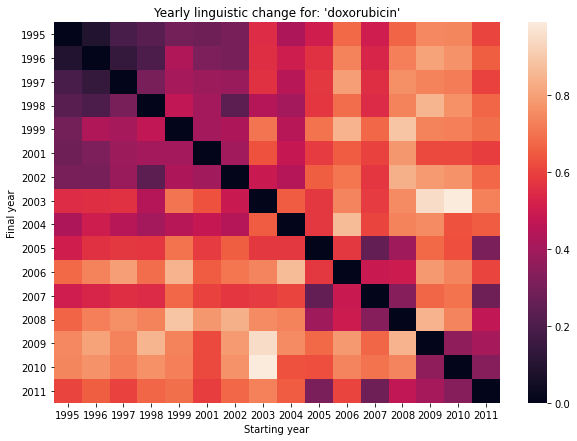

In [146]:
targetWord = wordDivergences[-1][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

## COHA

COHA is a historial dataset so it ends up being a good choice to try the same analysis we just did across three different time periods.

We will be using the same data loading procedure as the last notebook, so go through the process to make sure you know what's going on.

In [147]:
corpora_address = "/Users/flori/OneDrive/Desktop/UCHICAGO/NLP/Comutational Content Analysis/CCA_NLP/Homework-Notebooks-2023/data/COHA"

In [148]:
coha_texts = lucem_illud.loadDavies(corpora_address, return_raw=True)

text_1810s_kso.zip
text_1820s_jsi.zip
text_1830s_bsu.zip
text_1840s_nsq.zip
text_1850s_jpr.zip
text_1860s_psi.zip
text_1870s_vuy.zip
text_1880s_azz.zip
text_1890s_jsq.zip
text_1900s_mse.zip
text_1910s_jue.zip
text_1920s_gte.zip
text_1930s_bie.zip
text_1940s_bsw.zip
text_1950s_ndz.zip
text_1960s_xus.zip
text_1970s_jfy.zip
text_1980s_bkk.zip
text_1990s_bsj.zip
text_2000s_scc.zip


Cool - let us now create our different epochs. This is an important step: I will be using the same 5 epochs I did in the DTM example, but you are recommended to play around with this. I will create a dataframe which logs the year and the genre.

In [149]:
coha_df = pd.DataFrame(columns=["Year", "Genre", "Epoch", "normalized sents"])

In [150]:
for article in coha_texts:
    genre, year, id_ = article.split("_")

    year = int(year)
    
    if year > 1810 and year < 1880:
        epoch = 0
    if year >= 1880 and year < 1913:
        epoch = 1
    if year >= 1913 and year < 1950:
        epoch = 2
    if year >= 1950 and year < 1990:
        epoch = 3
    if year >= 1990:
        epoch = 4
    
    try:
        if len(coha_texts[article][2]) < 1500000:
            coha_df.loc[id_] = [year, genre, epoch, lucem_illud.normalizeTokens(coha_texts[article][2].decode("utf-8"), lemma=False)]
    except TypeError:
        continue
    except IndexError:
        continue

c:\Users\flori\AppData\Local\Programs\Python\Python39\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


We can now arrange our word embeddings by either year, genre, or epoch, and see how the words in each of those contexts change.

In [ ]:
rawEmbeddings_epoch = rawModels(coha_df, 'Epoch', text_column_name='normalized sents')

In [ ]:
# rawEmbeddings_genre = rawModels(coha_df, 'Genre', text_column_name='normalized sents')

We now have the raw embeddings for epoch and genre. You can test out the previous analysis on words of your choice.

In [ ]:
for epoch, embedding in enumerate(rawEmbeddings_epoch):
    model = rawEmbeddings_epoch[embedding]
    name = "embedding_epoch_" + str(epoch)
    model.save(name)

In [ ]:
# for embedding in rawEmbeddings_genre:
#     model = rawEmbeddings_genre[embedding]
#     name = "embedding_genre_" + embedding
#     model.save(name)

In [ ]:
from gensim.models import Word2Vec

In [ ]:
def file_to_embeddings(address, kind):
    rawEmbeddings = {}
    for file in os.listdir(address):
        if "embedding_"+kind in file:
            e, kind_, kind_type = file.split("_")
            kind_type = eval(kind_type)
            rawEmbeddings[kind_type] = Word2Vec.load(file)
    return rawEmbeddings

In [ ]:
# rawEmbeddings_genre_load = file_to_embeddings(".", "genre")

In [ ]:
rawEmbeddings_epoch_load = file_to_embeddings(".", "epoch")

In [ ]:
rawEmbeddings_epoch_load.keys()

In [ ]:
rawEmbeddings_epoch, compared_epoch = compareModels(coha_df, 'Epoch', text_column_name='normalized sents', embeddings_raw=rawEmbeddings_epoch_load)

In [ ]:
# rawEmbeddings_genre, compared_genre = compareModels(coha_df, 'Genre', text_column_name='normalized sents', embeddings_raw=rawEmbeddings_genre_load)

You now have access to the epoch wise embeddings, and the code to train models genre wise (commented out). You can use the original embeddings, the compared embeddings and such to perform the analysis we did before.

## <font color="red">*Exercise 4b*</font>

<font color="red">**Do only 4a or 4b.** Construct cells immediately below this that align word embeddings over time or across domains/corpora. Interrogate the spaces that result and ask which words changed most and least over the entire period or between contexts/corpora. What does this reveal about the social game underlying your space? 

In [238]:
merged_df['Epoch'] = merged_df['year'] - merged_df['year'].min()

# Verify the Epoch values
print(merged_df['Epoch'].unique())

# Define the directory to save the models
save_dir = '../word2vec_models'  # Adjust path as needed
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

def train_epoch_models(df, text_column_name='normalized_tokens'):
    raw_embeddings = {}
    epochs = sorted(set(df['Epoch']))
    for epoch in epochs:
        print("Training model for epoch", epoch)
        subset_df = df[df['Epoch'] == epoch]
        sentences = subset_df[text_column_name].tolist()

        # Diagnostic print statements
        print("Number of documents in epoch:", len(sentences))
        print("Example of first document's tokens:", sentences[0] if sentences else "No data")

        # Check if sentences list is empty
        if not sentences:
            print("No data for epoch", epoch)
            continue
            #vector_size
        model = gensim.models.Word2Vec(size=100, window=5, min_count=2, workers=4)
        model.build_vocab(sentences)
        
        # Check if vocabulary is built
        if model.wv.vocab:  # or model.wv.key_to_index in newer versions of gensim
            print("Vocabulary size for epoch", epoch, ":", len(model.wv.vocab))
            model.train(sentences, total_examples=model.corpus_count, epochs=20)
            raw_embeddings[epoch] = model
            # Save each model
            model_save_path = os.path.join(save_dir, f"word2vec_epoch_{epoch}.model")
            model.save(model_save_path)
            print(f"Model for epoch {epoch} saved in {model_save_path}")
        else:
            print("Failed to build vocabulary for epoch", epoch)

    return raw_embeddings

# Train the models for each epoch
raw_embeddings_epoch = train_epoch_models(merged_df)




[ 0. nan  1.  2.  3.  4.  5.  6.]
Training model for epoch 0.0
Number of documents in epoch: 763
Example of first document's tokens: ['grow', 'rapidly', 'expect', 'grow', 'cagr', 'end', 'digital', 'pathology', 'market', 'grow', 'rapidly', 'expect', 'reach', 'usd', 'end', 'global', 'digital', 'pathology', 'market', 'evaluate', 'rapidly', 'grow', 'market', 'expect', 'market', 'reach', 'high', 'growth', 'figure', 'tremendous', 'growth', 'number', 'people', 'getting', 'diagnose', 'deadly', 'disease', 'include', 'cancer', 'huge', 'demand', 'digital', 'pathology', 'pharmaceutical', 'biotechnology', 'company', 'reference', 'laboratory', 'benefit', 'offer', 'digital', 'pathology', 'phenomenon', 'have', 'high', 'importance', 'market', 'segmentation', 'digital', 'pathology', 'market', 'segment', 'basis', 'type', 'comprise', 'human', 'pathology', 'animal', 'pathology', 'basis', 'product', 'market', 'segment', 'scanner', 'storage', 'server', 'system', 'software', 'basis', 'application', 'market', 

Vocabulary size for epoch 0.0 : 13179
Model for epoch 0.0 saved in ../word2vec_models\word2vec_epoch_0.0.model
Training model for epoch nan
Number of documents in epoch: 0
Example of first document's tokens: No data
No data for epoch nan
Training model for epoch 1.0
Number of documents in epoch: 851
Example of first document's tokens: ['opioid', 'crisis', 'china', 'spar', 'blame', 'fentanyl', 'availability', 'matthew', 'hall', 'new', 'york', 'new', 'major', 'player', 'america', 'battle', 'opioid', 'china', 'name', 'important', 'ally', 'effort', 'deal', 'crippling', 'crisis', 'white', 'house', 'drug', 'official', 'warn', 'fentanyl', 'type', 'synthetic', 'heroin', 'strong', 'pain', 'medication', 'anaesthesia', 'risk', 'major', 'global', 'threat', 'ambulance', 'medics', 'john', 'gardner', 'leave', 'david', 'farmer', 'care', 'man', '40', 'find', 'unresponsive', 'overdose', 'opioid', 'boston', 'nurse', 'hospital', 'recognise', 'man', 'say', 'bring', 'day', 'overdose', 'photo', 'brian', 'sny

In [244]:
from gensim.models import Word2Vec
import numpy as np
from scipy.spatial.distance import cosine

def calculate_word_changes(word, models):
    distances = []
    for i in range(len(models) - 1):
        if word in models[i].wv.vocab and word in models[i + 1].wv.vocab:
            vec1 = models[i].wv[word]
            vec2 = models[i + 1].wv[word]
            distance = cosine(vec1, vec2)
            distances.append(distance)
    return np.mean(distances)

# Load the models
epochs = range(len(raw_embeddings_epoch))
models = [Word2Vec.load(os.path.join(save_dir, f"word2vec_epoch_{float(epoch)}.model")) for epoch in epochs]

# Calculate change for each word
word_changes = {}
for word in models[0].wv.vocab.keys():
    word_changes[word] = calculate_word_changes(word, models)

# Sort words by amount of change
most_changed_words = sorted(word_changes.items(), key=lambda x: x[1], reverse=True)
least_changed_words = sorted(word_changes.items(), key=lambda x: x[1])

# Analyze and interpret the results
print("Words that changed the most:", most_changed_words[:10])
print("Words that changed the least:", least_changed_words[:10])


c:\Users\flori\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\flori\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Words that changed the most: [('pacifica', 1.0730853155255318), ('persistence', 0.9499311662123849), ('analytics', 0.9142550427932292), ('evangelist', 0.9043386890552938), ('telecardiology', 0.903717614710331), ('t', 0.894340768805705), ('mantra', 0.8731717308983207), ('enduser', 0.8719334363316497), ('wise', 0.8707928483684858), ('devoted', 0.8673616540618241)]
Words that changed the least: [('new', 0.4772039403518041), ('high', 0.5029807686805725), ('download', 0.5062585324048996), ('www.mednax.com', 0.5084884911775589), ('market', 0.5157360285520554), ('people', 0.5269820640484492), ('social', 0.5289367785056432), ('couldcause', 0.5311801731586456), ('service', 0.532633957763513), ('provide', 0.5332991493244966)]


The results shows:
1. **Words that changed the most**: 
    - Words like 'pacifica', 'persistence', 'analytics', 'evangelist', 'telecardiology', 'mantra', 'enduser', 'wise', and 'devoted' are among those that have shown significant semantic shifts. 
    - These words likely represent emerging concepts, technologies, or trends that have gained prominence or evolved in meaning during the period studied. 
    - For instance, 'analytics' and 'telecardiology' might indicate a growing focus on data analysis and remote healthcare, respectively. 'Evangelist' in a modern context often refers to someone who promotes a particular technology or innovation, which could suggest an evolving role in the tech or business sectors. 
    - The high degree of change in these words suggests they are part of dynamic fields or concepts that are rapidly evolving.

2. **Words that changed the least**: 
    - Words like 'new', 'high', 'download', 'market', 'people', 'social', 'service', and 'provide' show minimal semantic change.
    - These words are more generic and broadly used across various contexts. Their meanings are more stable and less susceptible to rapid shifts. 
    - Their stability in meaning might indicate their fundamental role in communication within the studied domain, serving as foundational terms that are less influenced by specific trends or changes in the field.

**Insights on Social Dynamics**:
- The analysis reveals a dichotomy between dynamic and stable semantic fields in the corpus. 
- Words that changed the most are likely associated with evolving technology, societal trends, and emerging practices, reflecting innovation, adaptation, and shifts in focus or values within the studied period.
- Words that changed the least are foundational and serve as anchors in the language, ensuring continuity and comprehensibility despite the evolution in other terms.
- This duality highlights how some aspects of the field (or society) are in constant flux, adapting to new ideas and technologies, while others remain constant, providing a sense of stability and continuity.
- The specific words that have changed also provide insight into what areas have been most subject to change or innovation. For example, 'telecardiology' and 'analytics' suggest significant developments in healthcare and data science.
- Understanding these dynamics can help in predicting future trends, focusing research and development, and in strategic planning for businesses or educational programs within these fields.

There is much more we do not have time to cover on word embeddings. If you are interested in other ways to align word embeddings, take a look at the [Dynamic Word Embeddings (DTM) section from the Thinking with Deep Learning course](https://colab.research.google.com/drive/1RAiI3BIL1X9D4gzZ0rZdIJjkNNicIuKE?usp=sharing#scrollTo=COS_n2RFCJNk) or using the more recent [Temporal Word Embeddings with a Compass (TWEC) package](https://github.com/valedica/twec). There is also a useful section on [debiasing word embeddings](https://colab.research.google.com/drive/1RAiI3BIL1X9D4gzZ0rZdIJjkNNicIuKE?usp=sharing#scrollTo=JHQ--EsWoxGM), such as the famous, ["Man is to Computer Programmer as Woman is to Homemaker? Debiasing Word Embeddings"](https://arxiv.org/abs/1607.06520) paper. Below, we include an optional section on topic modeling with word embeddings, which could be useful for final projects.

## Optional: Topic modeling with word embeddings

Recently computer scientists have developed methods to cluster word embeddings, which can be viewed as a topic model, an embedding-based version of conventional topic models that use the document-term matrix (e.g., LDA). One method is Discourse Atoms, first described by Princeton NLP researchers ([Arora et al. 2018](https://arxiv.org/abs/1601.03764)). This uses k-SVD, a generalization of the k-means clustering algorithm to identify topic-like vectors in the n-dimensional word embedding space. Below is code adapted from the first social science paper using Discourse Atoms, [Arseniev-Koehler et al. 2021](https://osf.io/preprints/socarxiv/nkyaq/). It takes as input _gensim_ word vectors.

You are not required to implement this, but for class projects or your own research, this can be more useful than conventional topic models. It runs faster, produces more detailed topics, and in general makes use of more information (i.e., word order within a document) than do conventional topic models. Note there are at least 4 other papers with methods for word embedding clusters:

- Xun, Li, Zhao, Gao, and Zhang 2017: [multivariate Gaussian distributions](https://www.ijcai.org/proceedings/2017/588)
- Dieng, Ruiz, and Blei 2019: ["Embedding Topic Model (ETM)"](https://arxiv.org/abs/1907.04907)
- Angelov 2020: ["Top2Vec"](https://arxiv.org/abs/2008.09470)
- Sia, Dalmia, and Mielke 2020: [(spherical) k-means, k-medoids, von Mises-Fisher Models, Gaussian Mixture Models](https://arxiv.org/abs/2004.14914)

Let's implement the Discourse Atoms method.

In [ ]:
# from gensim.test.utils import datapath 
# import re
# import string, re
# import cython

In [ ]:
# The ksvd package has a convenient Approximate k-SVD function.
!pip install ksvd

In [2]:
from gensim import corpora, models, similarities #calc all similarities at once, from http://radimrehurek.com/gensim/tut3.html
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import KeyedVectors
from random import seed, sample
from ksvd import ApproximateKSVD #pip or conda install ksvd #this is key!

import pickle
import math

In [11]:
# Load a gensim word2vec model
w2v = senReleasesW2V

#### k-SVD

We then perform a K-SVD on the word embedding matrix to learn topics in such a way where each word-vector is represented as a spare linear combination of topics. To generate a good representation of the original word vector space, we want to minimize the difference between our word vectors and the vectors generated as a linear combination of topics. 




In [15]:
#### TRAIN MODEL:

#n_comp: Number of topics (i.e., atoms, or dictionary elements)
#n_nonzeros: Number of nonzero coefficients to target (how many atoms each word can load onto)
            
def do_aksvd(w2vmodel, n_comp, n_nonzeros, save=False, savelocation='/data/aksvd_models/'): 
    #https://github.com/nel215/ksvd #takes about 2 min on Alina's laptop for 30 atoms 
    aksvd_t = ApproximateKSVD(n_components=n_comp, transform_n_nonzero_coefs=n_nonzeros) #also may adjuste n iter which is default at 10, and tolerance for error which is default at  tol=1e-6 #n_components is number of discourse atoms, since vocab size is smallish, keep this fewer. transform_n is the number of atoms (components) that a word can be a linear combo of
    dictionary_t = aksvd_t.fit(w2vmodel.wv.vectors).components_ # Dictionary is the matrix of discourse atoms. 
    alpha_t = aksvd_t.transform(w2vmodel.wv.vectors) #get the alphas, which are the "weights" of each word on a discourse atoms

    if save==True:
        outfile = open(str(savelocation) + '200d_' + str(n_comp) + 'comp' + str(n_nonzeros) + 'nonzeros_aksvd_nvdrsdf20','wb')
        pickle.dump(aksvd_t,outfile)
        outfile.close()
        
        outfile = open(str(savelocation) + '200d_' +str(n_comp) + 'comp' + str(n_nonzeros) + 'nonzeros_dictionary_nvdrsdf20','wb')
        pickle.dump(dictionary_t,outfile)
        outfile.close()
        
        outfile = open(str(savelocation) + '200d_' + str(n_comp) + 'comp' + str(n_nonzeros) + 'nonzeros_alpha_nvdrsdf20','wb')
        pickle.dump(alpha_t,outfile)
        outfile.close()
    return(dictionary_t, alpha_t)

Two quick quality checks. These are useful to choose the number of atoms in the dictionary (i.e., number of topics): $R^2$ and Topic Diversity

Useful to look at product of the two since $R^2$ tends to increase with higher # topics, as Topic Diversity decreases. Intuition: more topics can better explain the original semantic space, but also then these topics are less distinct from one another. As a result, we typically want a balance between the two.

In [20]:
def reconst_qual(w2vmodel, dictionary_mat, alpha_mat):
    #reconstruct the word vectors
    reconstructed = alpha_mat.dot(dictionary_mat) #reconstruct word vectors and add back in mean(?). but note that reconstructed norm is still around 0-1, not 1, is that an issue?
    #e1 = norm(w2vmodel.wv.vectors - reconstructed) #total reconstruction error, larger means MORE error. norm as specified here takes frobenius norm of error matrix.


    #total VARIANCE in the data: sum of squares 
    squares3= w2vmodel.wv.vectors-np.mean(w2vmodel.wv.vectors, axis=1).reshape(-1,1) #https://dziganto.github.io/data%20science/linear%20regression/machine%20learning/python/Linear-Regression-101-Metrics/
    #sst3= np.sum([i.dot(i) for i in squares3] ) #same as below

    sst3= np.sum(np.square(squares3))


    #total sum of squared ERRORS/residuals
    e3= [reconstructed[i]-w2vmodel.wv.vectors[i] for i in range(0,len(w2vmodel.wv.vectors))]  #https://dziganto.github.io/data%20science/linear%20regression/machine%20learning/python/Linear-Regression-101-Metrics/
    #sse3= np.sum([i.dot(i) for i in e3] ) #same as below
    sse3= np.sum(np.square(e3))

    #R^2: 1- (SSE / SST )
    r2= 1- (sse3 /  sst3) #https://stats.stackexchange.com/questions/184603/in-pca-what-is-the-connection-between-explained-variance-and-squared-error


    #compute root mean square error
    rmse=  math.sqrt(np.mean(np.square(e3)))



    return(sse3, rmse, r2) #https://stats.stackexchange.com/questions/184603/in-pca-what-is-the-connection-between-explained-variance-and-squared-error

#### Inferring topics from document

We now use a similar approach to what we saw a little earlier, where we inverted our generative model to see which documents belong to which class - we do the same now, but with discourse atoms instead of the whole model. This process tells us the topic most likely to have generated a specific context (document). 



In [13]:
#topic diversity (% unique words among total closest 25 words to each atom)
def topic_diversity(w2vmodel, dictionary_mat, top_n=25):

    topwords=[] #list of list, each innter list includes top N words in that topic

    for i in range(0, len(dictionary_mat)): #set to number of total topics
        topwords.extend([i[0] for i in w2vmodel.wv.similar_by_vector(dictionary_mat[i],topn=top_n)]) #set for top N words 
        #print(w2vmodel.wv.similar_by_vector(dictionary[i],topn=N))

    uniquewords= set(topwords)
    diversity = len(uniquewords)/len(topwords)
    return(diversity)

In [17]:
dictionary, alpha = do_aksvd(w2v, 150, 5, save=False)

In [18]:
topic_diversity(w2v, dictionary, top_n=25)

0.7912

In [21]:
reconst_qual(w2v, dictionary, alpha)


(15388.558191774388, 0.10584462888050881, 0.8778765213825936)

In [22]:
#loading back in the model pieces if not already in

# infile = open('../data/aksvd_models/200d_150comp5nonzeros_dictionary_nvdrsdf20','rb')
# dictionary=pickle.load(infile)
# infile.close()

# infile = open('../data/aksvd_models/200d_150comp5nonzeros_aksvd_nvdrsdf20','rb')
# aksvd=pickle.load(infile)
# infile.close()

# infile = open('../data/aksvd_models/200d_150comp5nonzeros_alpha_nvdrsdf20','rb')
# alpha=pickle.load(infile)
# infile.close()

In [23]:
for i in range(0, len(dictionary)):
    print("Discourse_Atom " + str(i))
    print([i[0] for i in w2v.wv.similar_by_vector(dictionary[i],topn=25)]) #what are the most similar words to the Nth
    #print([i[0] for i in w2vmodel.wv.similar_by_vector(-dictionary[i],topn=25)]) #what are the most similar words to the Nth dicourse atom?
    print('\n')


Discourse_Atom 0
['troops', 'soldiers', 'combat', 'iraqis', 'forces', 'afghanistan', 'uparmored', 'insurgency', 'casualties', 'sending', 'deployments', 'duty', 'wounded', 'withdrawal', 'return', 'iraq', 'military', 'presence', 'deployment', 'stable', 'refugees', 'troop', 'armor', 'ground', 'humvees']


Discourse_Atom 1
['fuels', 'biofuels', 'cellulosic', 'producers', 'efficiency', 'ethanol', 'fuel', 'fossil', 'crops', 'e85', 'carbon', 'cars', 'biomass', 'renewable', 'solar', 'greenhouse', 'coal', 'sources', 'diesel', 'environmentally', 'gases', 'plug', 'supply', 'liquid', 'dioxide']


Discourse_Atom 2
['experience', 'assessment', 'skills', 'recruitment', 'superb', 'goals', 'trained', 'professional', 'field', 'knowledge', 'involvement', 'head', 'recruiting', 'open', 'train', 'training', 'starts', 'succeed', 'mission', 'teachers', 'early', 'changing', 'goal', 'learn', 'benchmarks']


Discourse_Atom 3
['classes', 'prep', 'proficient', 'certificate', 'enrolling', 'ged', 'paraprofessionals'

In [24]:
# for a specific atom, e.g., 112th atom look at 25 most similar words:
w2v.wv.similar_by_vector(dictionary[112],topn=25)

[('released', 0.8307494521141052),
 ('issued', 0.8278462290763855),
 ('following', 0.8144934177398682),
 ('indicating', 0.8013809323310852),
 ('paulison', 0.7693773508071899),
 ('requests', 0.7669892311096191),
 ('requesting', 0.7619739770889282),
 ('attached', 0.7577342987060547),
 ('submitted', 0.7547256946563721),
 ('outlining', 0.754010021686554),
 ('text', 0.7535538673400879),
 ('letter', 0.7525202035903931),
 ('follows', 0.7458902597427368),
 ('copy', 0.7440081834793091),
 ('urging', 0.739249050617218),
 ('statement', 0.7312683463096619),
 ('findings', 0.7294003367424011),
 ('signing', 0.7228908538818359),
 ('everson', 0.721015214920044),
 ('noaa', 0.7209566831588745),
 ('response', 0.720012903213501),
 ('detailing', 0.7143642902374268),
 ('detailed', 0.7143552303314209),
 ('pdb', 0.7120823860168457),
 ('draft', 0.7062597274780273)]

In [29]:
print(w2v.wv.vocab.get('draft').index, '\n', alpha[w2v.wv.vocab.get('draft').index])


3269 
 [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.68042272  1.57690927  0.         -0.54061927
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.41337639
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  

In [30]:
#useful relevant code:
w2v.wv.index2word[3452]
w2v.wv.most_similar('draft', topn=15)
np.where(alpha[w2v.wv.vocab.get('draft').index] != 0) #get index where the loading of a word onto discourse atoms is not 0

(array([ 20,  21,  23,  77, 122], dtype=int64),)